# Testing pseudopeople before the Yellow Release

I'm looking at this version of the docs: https://pseudopeople--268.org.readthedocs.build/en/268/ from https://github.com/ihmeuw/pseudopeople/pull/268

In [1]:
! date
! whoami

Fri Sep  1 16:50:20 PDT 2023
zmbc


In [2]:
! pip freeze | grep pseudopeople

pseudopeople @ git+https://github.com/ihmeuw/pseudopeople.git@1f468169be1c334cde1350fcda7d9a2d49ec9ffb


In [3]:
# A clickable link to the GitHub UI to see what version I'm using
! pip freeze | grep pseudopeople | sed -e 's|pseudopeople @ ||' | sed -e 's|git+||' | sed -e 's|\.git@|/tree/|'

https://github.com/ihmeuw/pseudopeople/tree/1f468169be1c334cde1350fcda7d9a2d49ec9ffb


In [4]:
import pseudopeople as psp

## Looking for data problems

In [5]:
census = psp.generate_decennial_census()

In [6]:
census_nonoise = psp.generate_decennial_census(config=psp.NO_NOISE)

In [7]:
census

,simulant_id,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year
0,0_2,0_7,Diana,P,Kelly,25,05/06/1994,5112,145th st,NaN,Anytown,WA,00000,Household,Reference person,Female,NaN,2020
1,0_3,0_7,Anna,A,Kelly,25,09/29/1994,5112,145th st,NaN,Anytown,WA,00000,Household,Other relative,Female,White,2020
2,0_923,0_8033,Gerald,R,Allen,76,11/03/1943,1130,mallory ln,NaN,Anytown,WA,00000,Household,Reference person,Male,Black,2020
3,0_2641,0_1066,Loretta,T,Lowe,61,06/01/1958,32597,delacorte dr,NaN,Anytown,WA,00000,Household,Reference person,Female,White,2020
4,0_2801,0_1138,Richard,R,Pinard,73,03/03/1947,950,caribou lane,NaN,Anytown,WA,00000,Household,Reference person,Male,White,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10215,0_18969,0_7630,Patty,E,Palmisano,87,01/11/1933,1706,lincoln ave se,NaN,Anytown,WA,00000,Household,Opposite-sex spouse,Female,White,2020
10216,0_19008,0_8361,John,V,Skeeter,58,12/29/1961,7736,trophy dr,NaN,Anytown,WA,00000,Household,Reference person,Male,Black,2020
10217,0_20165,0_7999,Kimberly,K,Suitt,65,04/05/1955,3506,oneill avenue,NaN,Anytown,WA,00000,Household,Reference person,Female,White,2020
10218,0_19020,0_8130,Virginia,G,Hoover,93,10/02/1926,201,edinburgh rd,NaN,Anytown,WA,00000,Household,Reference person,Female,White,2020


In [8]:
# Types
for col in census.columns:
    print(census[col].map(type).value_counts().sort_values())
    # One for NaNs, one for non-missing values
    assert census[col].map(type).nunique() <= 2

<class 'str'>    10220
Name: simulant_id, dtype: int64
<class 'str'>    10220
Name: household_id, dtype: int64
<class 'float'>       94
<class 'str'>      10126
Name: first_name, dtype: int64
<class 'float'>      101
<class 'str'>      10119
Name: middle_initial, dtype: int64
<class 'float'>       86
<class 'str'>      10134
Name: last_name, dtype: int64
<class 'float'>       83
<class 'str'>      10137
Name: age, dtype: int64
<class 'float'>      103
<class 'str'>      10117
Name: date_of_birth, dtype: int64
<class 'float'>     446
<class 'str'>      9774
Name: street_number, dtype: int64
<class 'float'>      109
<class 'str'>      10111
Name: street_name, dtype: int64
<class 'str'>       493
<class 'float'>    9727
Name: unit_number, dtype: int64
<class 'float'>      102
<class 'str'>      10118
Name: city, dtype: int64
<class 'str'>    10109
Name: state, dtype: int64
<class 'float'>       98
<class 'str'>      10122
Name: zipcode, dtype: int64
<class 'float'>       94
<class 'str'> 

### Look at "weird values"

In [9]:
from IPython.display import display, Markdown

import pandas as pd
pd.set_option('display.max_columns', None)

# https://stackoverflow.com/a/18403812/
def isascii(s):
    """Check if the characters in string s are in ASCII, U+0-U+7F."""
    return len(s) == len(s.encode())

def compare_noised(df):
    df = df.set_index('simulant_id')
    return df.compare(
        census_nonoise.set_index('simulant_id').reindex(df.index),
        keep_shape=True,
        keep_equal=True,
        result_names=('noised', 'original'),
    )

for col in census.columns:
    display(Markdown(f'### {col}'))
    display(Markdown('#### Highest and lowest'))
    display(compare_noised(census[census[col].notnull()].sort_values(col)))
    display(Markdown('#### Longest and shortest'))
    display(compare_noised(census.assign(length=census[col].astype(str).str.len())[census[col].notnull()].sort_values('length').drop(columns=['length'])))
    display(Markdown('#### Special characters'))
    display(Markdown('##### Non-alphanumeric'))
    display(compare_noised(census[~census[col].astype(str).str.isalnum()]))
    display(Markdown('##### Non-ASCII'))
    display(compare_noised(census[~census[col].astype(str).map(isascii)]))

### simulant_id

#### Highest and lowest

household_id          first_name          middle_initial           \
                  noised original     noised original         noised original   
simulant_id                                                                     
0_100               0_46     0_46        Eva      Eva              P        P   
0_10000           0_4069   0_4069       Eric     Eric              J        J   
0_10001           0_4069   0_4069     Amanda   Amanda              M        M   
0_10002           0_4069   0_4069    Alberto  Alberto              K        K   
0_10003           0_4070   0_4070    Felicia  Felicia              L        L   
...                  ...      ...        ...      ...            ...      ...   
0_999              0_403    0_403       Lois     Lois              C        C   
0_9990               0_3      0_3     Nicole   Nicole              L        L   
0_9993            0_4066   0_4066        NaN   Edward              R        R   
0_9994            0_4066   0_4066      Linda    Linda              C        C   
0_9999            0_4069   0_4069      Donna    Donna              J        J   

             last_name               age          date_of_birth              \
                noised   original noised original        noised    original   
simulant_id                                                                   
0_100          Magwood    Magwood     76       76    12/08/1943  12/08/1943   
0_10000       Espinoza   Espinoza     48       48    02/15/1972  02/15/1972   
0_10001       Espinoza   Espinoza     37       37    07/10/1982  07/10/1982   
0_10002       Espinoza   Espinoza     13       13    08/02/2006  08/02/2006   
0_10003      Blackburn  Blackburn     49       49    03/08/1971  03/08/1971   
...                ...        ...    ...      ...           ...         ...   
0_999          Batista    Batista     72       72    02/29/1948  02/29/1948   
0_9990         Plumlee    Plumlee     19       19    03/28/2000  03/28/2000   
0_9993          Brimer     Brimer     75       75    02/19/1945  02/19/1945   
0_9994          Brimer     Brimer     73       73    04/07/1946  04/07/1946   
0_9999        Espinoza   Espinoza     69       69    11/29/1950  11/29/1950   

            street_number                   street_name                       \
                   noised original               noised             original   
simulant_id                                                                    
0_100                9279     9279        horsham trail        horsham trail   
0_10000              4638     4638          tongass ave          tongass ave   
0_10001              4638     4638          tongass ave          tongass ave   
0_10002              4638     4638          tongass ave          tongass ave   
0_10003             15425    15425        sw stevens st        sw stevens st   
...                   ...      ...                  ...                  ...   
0_999                 NaN      NaN            apsley st            apsley st   
0_9990               8203     8203  west farwell avenue  west farwell avenue   
0_9993                343      343            auburn st            auburn st   
0_9994                343      343            auburn st            auburn st   
0_9999               4638     4638          tongass ave          tongass ave   

            unit_number                city           state          zipcode  \
                 noised   original   noised original noised original  noised   
simulant_id                                                                    
0_100               NaN        NaN  Anytown  Anytown     WA       WA   00000   
0_10000             NaN        NaN  Anytown  Anytown     WA       WA   00000   
0_10001             NaN        NaN  Anytown  Anytown     WA       WA   00000   
0_10002             NaN        NaN  Anytown  Anytown     OH       WA   00000   
0_10003             NaN        NaN  Anytown  Anytown     WA       WA   00000   
...      

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3                  0_7      0_7       Anna      Anna              A   
0_9               0_6357   0_6357     Elijah    Elijah              N   
0_6                  0_8      0_8       Elan      Elan              N   
0_5                  0_8      0_8       Erin      Erin              R   
...                  ...      ...        ...       ...            ...   
0_13082           0_5269   0_5269       Anna      Anna              K   
0_15799           0_6378   0_6378       Liam      Liam              J   
0_15798           0_6378   0_6378      Sandy     Sandy              L   
0_11455           0_4634   0_4634    Jessica   Jessica              E   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                         last_name                  age           \
            original        noised      original noised original   
simulant_id                                                        
0_2                P         Kelly         Kelly     25       25   
0_3                A         Kelly         Kelly     25       25   
0_9                N      Gonzalez      Gonzalez      4        4   
0_6                N  Stark Lozano  Stark Lozano      6        6   
0_5                R  Stark Lozano  Stark Lozano     40       40   
...              ...           ...           ...    ...      ...   
0_13082            K  Garcia Jones  Garcia Jones     60       60   
0_15799            J         Abdon         Abdon     16       16   
0_15798            L          Mohr          Mohr     60       60   
0_11455            E          Ward          Ward     59       59   
0_20163            R       Simmons       Simmons     27       27   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_2            05/06/1994  05/06/1994          5112     5112   
0_3            09/29/1994  09/29/1994          5112     5112   
0_9            10/31/2015  10/31/2015          1648     1648   
0_6            07/30/2013  07/30/2013          1501     1501   
0_5            10/27/1979  10/27/1979          1501     1501   
...                   ...         ...           ...      ...   
0_13082        02/04/1960  02/04/1960          1314     1314   
0_15799        03/02/2004  03/02/2004           310      310   
0_15798        01/28/1960  01/28/1960           310      310   
0_11455        05/02/1960  05/02/1960          6772     6772   
0_20163        04/21/1992  04/21/1992         27607    27607   

                  street_name                   unit_number              city  \
                       noised          original      noised original   noised   
simulant_id                                                                     
0_2                  145th st          145th st         NaN      NaN  Anytown   
0_3                  145th st          145th st         NaN      NaN  Anytown   
0_9             eagle heights     eagle heights         NaN      NaN  Anytown   
0_6           interlake ave n   interlake ave n         NaN      NaN  Anytown   
0_5           interlake ave n   interlake ave n         NaN      NaN  Anytown   
...                       ...               ...         ...      ...      ...   
0_13082            w 51st ave        w 51st ave         NaN      NaN  Anytown   
0_15799      west 54th street  west 54th street         NaN      NaN  Anytown   
0_15798      west 54th street  west 54th street         NaN      NaN  Anytown   
0_11455         bahia vsta st     bahia vsta st         NaN      NaN  Anytown   
0_20163        green lodge ct    green lodge ct         NaN      NaN  Anytown   

    

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3                  0_7      0_7       Anna      Anna              A   
0_923             0_8033   0_8033     Gerald    Gerald              R   
0_2641            0_1066   0_1066    Loretta   Loretta              T   
0_2801            0_1138   0_1138    Richard   Richard              R   
...                  ...      ...        ...       ...            ...   
0_18969           0_7630   0_7630      Patty     Patty              E   
0_19008           0_8361   0_8361       John      John              V   
0_20165           0_7999   0_7999   Kimberly  Kimberly              K   
0_19020           0_8130   0_8130   Virginia  Virginia              G   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_2                P      Kelly      Kelly     25       25    05/06/1994   
0_3                A      Kelly      Kelly     25       25    09/29/1994   
0_923              R      Allen      Allen     76       76    11/03/1943   
0_2641             T       Lowe       Lowe     61       61    06/01/1958   
0_2801             R     Pinard     Pinard     73       73    03/03/1947   
...              ...        ...        ...    ...      ...           ...   
0_18969            E  Palmisano  Palmisano     87       87    01/11/1933   
0_19008            V    Skeeter    Skeeter     58       58    12/29/1961   
0_20165            K      Suitt      Suitt     65       65    04/05/1955   
0_19020            G     Hoover     Hoover     93       93    10/02/1926   
0_20163            R    Simmons    Simmons     27       27    04/21/1992   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_2          05/06/1994          5112     5112        145th st   
0_3          09/29/1994          5112     5112        145th st   
0_923        11/03/1943          1130     1130      mallory ln   
0_2641       06/01/1958         32597    32597    delacorte dr   
0_2801       03/03/1947           950      950    caribou lane   
...                 ...           ...      ...             ...   
0_18969      01/11/1933          1706     1706  lincoln ave se   
0_19008      12/29/1961          7736     7736       trophy dr   
0_20165      04/05/1955          3506     3506   oneill avenue   
0_19020      10/02/1926           201      201    edinburgh rd   
0_20163      04/21/1992         27607    27607  green lodge ct   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_2                145th st         NaN      NaN  Anytown  Anytown     WA   
0_3                145th st         NaN      NaN  Anytown  Anytown     WA   
0_923            mallory ln         NaN      NaN  Anytown  Anytown     WA   
0_2641         delacorte dr         NaN      NaN  Anytown  Anytown     WA   
0_2801         caribou lane         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_18969      lincoln ave se         NaN      NaN  Anytown  Anytown     WA   
0_19008           trophy dr         NaN      NaN  Anytown  Anytown     WA   
0_20165       oneill avenue         NaN      NaN  Anytown  Anytown     WA   
0_19020        edinburgh rd         NaN      NaN  Anytown  Anytown     WA  

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### household_id

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_19722              0_0      0_0        Boy      Alan              J   
0_19889              0_0      0_0    William   William              M   
0_19887              0_0      0_0     Elaine    Elaine              S   
0_19880              0_0      0_0      Ellen     Ellen              G   
0_19879              0_0      0_0    Loretta   Loretta              W   
...                  ...      ...        ...       ...            ...   
0_2478             0_996    0_996   Katheryn  Katheryn              A   
0_2480             0_996    0_996      Mason     Mason              A   
0_2487             0_998    0_998    Charles   Charles              J   
0_2488             0_998    0_998    Rebecca   Rebecca              R   
0_2489             0_998    0_998   Kimberly  Kimberly              S   

                     last_name              age          date_of_birth  \
            original    noised  original noised original        noised   
simulant_id                                                              
0_19722            J      Cruz      Cruz     73       73    08/19/1946   
0_19889            M    Graham    Graham     56       56    07/15/1963   
0_19887            S  Ferguson  Ferguson     64       64    07/19/1955   
0_19880            G     Salem     Salem     80       80    03/28/1939   
0_19879            W  Jeffreys  Jeffreys     88       88    11/13/1931   
...              ...       ...       ...    ...      ...           ...   
0_2478             A    Rogers    Rogers     32       32    11/29/1987   
0_2480             A    Rogers    Rogers      7        7    04/29/2012   
0_2487             J    Prince    Prince     70       70    05/13/1949   
0_2488             R    Prince    Prince     52       52    04/13/1967   
0_2489             S  Williams  Williams     25       25    12/23/1994   

                        street_number            street_name                \
               original        noised original        noised      original   
simulant_id                                                                  
0_19722      08/19/1946          1231     1231  riverside dr  riverside dr   
0_19889      07/15/1963          1231     1231  riverside dr  riverside dr   
0_19887      07/19/1955          1231     1231  riverside dr  riverside dr   
0_19880      03/28/1939          1231     1231  riverside dr  riverside dr   
0_19879      11/13/1931          1231     1231  riverside dr  riverside dr   
...                 ...           ...      ...           ...           ...   
0_2478       11/29/1987         10200    10200   a forest st   a forest st   
0_2480       04/29/2012         10200    10200   a forest st   a forest st   
0_2487       05/13/1949          1121     1121       lida ct       lida ct   
0_2488       04/13/1967          1121     1121       lida ct       lida ct   
0_2489       12/23/1994          1121     1121       lida ct       lida ct   

            unit_number              city           state          zipcode  \
                 noised original   noised original noised original  noised   
simulant_id                                                                  
0_19722             NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_19889             NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_19887             NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_19880             NaN      NaN  Anytown  Anytown     OK       WA   00000   
0_19879             NaN      NaN  Anytown  Anytown     WA       WA   00000   
...                 ...      ...      ...      ...    ...      ...     ...   
0_2478              NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_2480              NaN      NaN  Anytown  Anytown     WA       WA   00000   
0

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_19523              0_4      0_4      Maeco     Marco              C   
0_19529              0_4      0_4       Eric      Eric              J   
0_19531              0_4      0_4     Hunter    Hunter              J   
0_19536              0_4      0_4      Jamya     Jamya              T   
...                  ...      ...        ...       ...            ...   
0_17905           0_7209   0_7209     Steven    Steven              M   
0_17904           0_7209   0_7209      Vicky     Vicky              P   
0_17537           0_7061   0_7061     Dakota    Dakota              C   
0_3889            0_1583   0_1583       Gary      Gary              P   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                         last_name                  age           \
            original        noised      original noised original   
simulant_id                                                        
0_2                P         Kelly         Kelly     25       25   
0_19523            C       Vallejo       Vallejo     21       21   
0_19529            J  Patel-Nguyen  Patel-Nguyen     35       35   
0_19531            J        Joseph        Joseph     18       18   
0_19536            T          Bohn          Bohn     19       19   
...              ...           ...           ...    ...      ...   
0_17905            M      Belville      Belville     55       55   
0_17904            P      Belville      Belville     57       57   
0_17537            C     Mccormack     Mccormack     23       23   
0_3889             P        Weldon        Weldon     50       50   
0_20163            R       Simmons       Simmons     27       27   

            date_of_birth             street_number               street_name  \
                   noised    original        noised original           noised   
simulant_id                                                                     
0_2            05/06/1994  05/06/1994          5112     5112         145th st   
0_19523        04/29/1998  04/29/1998            69       69        s hwy 701   
0_19529        07/16/1984  07/16/1984            69       69        s hwy 701   
0_19531               NaN  07/07/2001            69       69        s hwy 701   
0_19536        07/05/2000  07/05/2000            69       69        s hwy 701   
...                   ...         ...           ...      ...              ...   
0_17905        10/11/1964  10/11/1964           111      111  lake miriam cir   
0_17904        01/24/1963  01/24/1963           111      111  lake miriam cir   
0_17537        08/30/1996  08/30/1996          4932     4932   chalkstone ave   
0_3889         06/03/1969  06/03/1969            76       76           nc 181   
0_20163        04/21/1992  04/21/1992         27607    27607   green lodge ct   

                             unit_number              city           state  \
                    original      noised original   noised original noised   
simulant_id                                                                  
0_2                 145th st         NaN      NaN  Anytown  Anytown     WA   
0_19523            s hwy 701         NaN      NaN  Anytown  Anytown     WA   
0_19529            s hwy 701         NaN      NaN  Anytown  Anytown     WA   
0_19531            s hwy 701         NaN      NaN  Anytown  Anytown     WA   
0_19536            s hwy 701         NaN      NaN  Anytown  Anytown     WA   
...                      ...         ...      ...      ...      ...    ...   
0_17905      lake miriam cir         NaN      NaN  Anytown  Anytown     WA   
0_17904      lake miriam cir         NaN      NaN  Anytown  Anytown     WA   
0_17537       chalkstone ave         NaN   

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3                  0_7      0_7       Anna      Anna              A   
0_923             0_8033   0_8033     Gerald    Gerald              R   
0_2641            0_1066   0_1066    Loretta   Loretta              T   
0_2801            0_1138   0_1138    Richard   Richard              R   
...                  ...      ...        ...       ...            ...   
0_18969           0_7630   0_7630      Patty     Patty              E   
0_19008           0_8361   0_8361       John      John              V   
0_20165           0_7999   0_7999   Kimberly  Kimberly              K   
0_19020           0_8130   0_8130   Virginia  Virginia              G   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_2                P      Kelly      Kelly     25       25    05/06/1994   
0_3                A      Kelly      Kelly     25       25    09/29/1994   
0_923              R      Allen      Allen     76       76    11/03/1943   
0_2641             T       Lowe       Lowe     61       61    06/01/1958   
0_2801             R     Pinard     Pinard     73       73    03/03/1947   
...              ...        ...        ...    ...      ...           ...   
0_18969            E  Palmisano  Palmisano     87       87    01/11/1933   
0_19008            V    Skeeter    Skeeter     58       58    12/29/1961   
0_20165            K      Suitt      Suitt     65       65    04/05/1955   
0_19020            G     Hoover     Hoover     93       93    10/02/1926   
0_20163            R    Simmons    Simmons     27       27    04/21/1992   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_2          05/06/1994          5112     5112        145th st   
0_3          09/29/1994          5112     5112        145th st   
0_923        11/03/1943          1130     1130      mallory ln   
0_2641       06/01/1958         32597    32597    delacorte dr   
0_2801       03/03/1947           950      950    caribou lane   
...                 ...           ...      ...             ...   
0_18969      01/11/1933          1706     1706  lincoln ave se   
0_19008      12/29/1961          7736     7736       trophy dr   
0_20165      04/05/1955          3506     3506   oneill avenue   
0_19020      10/02/1926           201      201    edinburgh rd   
0_20163      04/21/1992         27607    27607  green lodge ct   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_2                145th st         NaN      NaN  Anytown  Anytown     WA   
0_3                145th st         NaN      NaN  Anytown  Anytown     WA   
0_923            mallory ln         NaN      NaN  Anytown  Anytown     WA   
0_2641         delacorte dr         NaN      NaN  Anytown  Anytown     WA   
0_2801         caribou lane         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_18969      lincoln ave se         NaN      NaN  Anytown  Anytown     WA   
0_19008           trophy dr         NaN      NaN  Anytown  Anytown     WA   
0_20165       oneill avenue         NaN      NaN  Anytown  Anytown     WA   
0_19020        edinburgh rd         NaN      NaN  Anytown  Anytown     WA  

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### first_name

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_17384           0_7001   0_7001     8onnie    Bonnie              D   
0_18273           0_7349   0_7349          A  Benjamin              C   
0_9019            0_3662   0_3662    Aaliyah   Aaliyah              I   
0_15531           0_6268   0_6268    Aaliyah   Aaliyah              H   
0_11330           0_4586   0_4586    Aaliyah   Aaliyah              I   
...                  ...      ...        ...       ...            ...   
0_10645           0_4326   0_4326       Zoey      Zoey              E   
0_4807            0_1968   0_1968       Zoey      Zoey              A   
0_20413           0_6290   0_6290       Zoey      Zoey              A   
0_6019            0_2450   0_2450       Zoey      Zoey              A   
0_5159            0_2113   0_2113       Zoey      Zoey              A   

                       last_name                age          date_of_birth  \
            original      noised    original noised original        noised   
simulant_id                                                                  
0_17384            D          Xu          Xu     50       50    04/30/1969   
0_18273            C      Thomas      Thomas     33       33    10/03/1986   
0_9019             I       Yoder       Yoder      9        9    02/27/2011   
0_15531            H  Mendenhall  Mendenhall      5        5    12/20/2014   
0_11330            I      Murphy      Murphy      7        7    12/15/2012   
...              ...         ...         ...    ...      ...           ...   
0_10645            E       Moore       Moore      7        7    12/30/2012   
0_4807             A       Hines       Hines      9        9    09/08/2010   
0_20413            A        Will        Will      0        0    02/01/1973   
0_6019             A       Lewis       Lewis      2        2    12/08/2017   
0_5159             A       Bolin       Bolin     11       11    03/14/2009   

                        street_number                    street_name  \
               original        noised original                noised   
simulant_id                                                            
0_17384      04/30/1969             9        9            hickory dr   
0_18273      10/03/1986           827      827            clark road   
0_9019       02/27/2011          2255     2255          vint hill rd   
0_15531      12/20/2014          2241     2241            poyntz ave   
0_11330      12/15/2012           217      217  south calumet avenue   
...                 ...           ...      ...                   ...   
0_10645      12/30/2012           106      106            aldrich wy   
0_4807       09/08/2010           NaN     4828         w lincoln ave   
0_20413      03/09/2020         19517    19517           37th street   
0_6019       12/08/2017          3220     3220                  g st   
0_5159       03/14/2009          3165     3165             w fawn dr   

                                   unit_number                  city           \
                         original       noised     original   noised original   
simulant_id                                                                     
0_17384                hickory dr          NaN          NaN  Anytown  Anytown   
0_18273                clark road          NaN          NaN  Anytown  Anytown   
0_9019               vint hill rd  unit # 1013  unit # 1013  Anytown  Anytown   
0_15531                poyntz ave          NaN          NaN  Anytown  Anytown   
0_11330      south calumet avenue          NaN          NaN  Anytown  Anytown   
...                           ...          ...          ...      ...      ...   
0_10645                aldrich wy          NaN          NaN  Anytown  Anytown   
0_4807              w lincoln ave          NaN          NaN  Anytown  Anytown

#### Longest and shortest

household_id              first_name               middle_initial  \
                  noised original         noised      original         noised   
simulant_id                                                                     
0_17437           0_7022   0_7022              P        Maggie              L   
0_1240            0_3207   0_3207              R       Vanessa              H   
0_17221           0_6941   0_6941              C        Nathan              J   
0_10602           0_4309   0_4309              W         David              J   
0_8792            0_3571   0_3571              V        Kelsey              L   
...                  ...      ...            ...           ...            ...   
0_3432            0_1393   0_1393   Konstantinos  Konstantinos              G   
0_11901           0_4806   0_4806   Gentleman Of     Alejandro              S   
0_8776            0_3563   0_3563  Lady Of House          Noah              A   
0_11640           0_4706   0_4706  Granddaughter       Bennett            NaN   
0_14408           0_5800   0_5800  Granddaughter        Evelyn              M   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_17437            L    Mcgrath    Mcgrath     33       33    06/05/1986   
0_1240             H      Eells      Eells     77       25    07/29/1994   
0_17221            J    Moffett    Moffett    NaN        2    06/10/2017   
0_10602            J      Ochoa      Ochoa     13       13    06/07/2006   
0_8792             L  Weinhandl  Weinhandl     28       28    11/26/1991   
...              ...        ...        ...    ...      ...           ...   
0_3432             G     Crespo     Crespo     39       39    05/22/1980   
0_11901            S     Cronin     Cronin     48       48    01/30/1972   
0_8776             A      Velez      Velez     38       38    11/06/1981   
0_11640            B       Cook       Cook      4        4    08/14/2015   
0_14408            M     Martin     Martin      7        7    06/02/2012   

                        street_number                   street_name  \
               original        noised original               noised   
simulant_id                                                           
0_17437      06/05/1986           624      624              n 200 e   
0_1240       07/29/1994          2025     2025             ruppe st   
0_17221      06/10/2017            21       21            coral str   
0_10602      06/07/2006          4427     4427         arkwright st   
0_8792       11/26/1991            89       89    south parker road   
...                 ...           ...      ...                  ...   
0_3432       05/22/1980          2276     2276           cavalry ct   
0_11901      01/30/1972         11101    11101  north howard street   
0_8776       11/06/1981          1684     1684        richmond road   
0_11640      08/14/2015          3500     3500         linvbdrgh av   
0_14408      06/02/2012           885      885       bonnefoy place   

                                 unit_number              city           \
                        original      noised original   noised original   
simulant_id                                                               
0_17437                  n 200 e         NaN      NaN  Anytown  Anytown   
0_1240                  ruppe st         NaN      NaN  Anytown  Anytown   
0_17221                coral str         NaN      NaN  Anytown  Anytown   
0_10602             arkwright st         NaN      NaN  Anytown  Anytown   
0_8792         south parker road         NaN      NaN  Anytown  Anytown   
...                          ...         ...      ...      ...      ...   
0_3432                cavalry ct         NaN      NaN  Anytown  Anytown   
0_11901      north howard street         NaN      NaN  Anytown  Any

#### Special characters

##### Non-alphanumeric

household_id              first_name             middle_initial  \
                  noised original         noised    original         noised   
simulant_id                                                                   
0_19912              0_0      0_0    Lady In The       Kacie              M   
0_142               0_64     0_64         Son Of        Anna              A   
0_264              0_109    0_109   Gentleman Of      Andrea              A   
0_268              0_110    0_110        Magg'le      Maggie              S   
0_19270           0_7742   0_7742          J'lll        Jill              M   
0_16393           0_6613   0_6613     Male Child      Daniel              J   
0_495              0_203    0_203   Gentleman Of      Joshua              B   
0_702              0_281    0_281    Lady Of The       Kenia              A   
0_20209              0_3      0_3      E|izabeth   Elizabeth              J   
0_1390             0_557    0_557       Benjam:n    Benjamin              R   
0_8039            0_3272   0_3272   Female Child    Danielle              R   
0_11074           0_4494   0_4494           L.R.       Leroy              W   
0_8776            0_3563   0_3563  Lady Of House        Noah              A   
0_14552           0_5861   0_5861         Son Of        Zoey              E   
0_8819            0_3582   0_3582     Male Child  Giancarlos              F   
0_11901           0_4806   0_4806   Gentleman Of   Alejandro              S   
0_2988            0_1213   0_1213        Den'lse      Denise              L   
0_5673            0_2310   0_2310        Child F      Philip              R   
0_18182           0_7310   0_7310     Male Child     Barbara              R   
0_5021            0_4768   0_4768     Dom'lnique   Dominique              M   
0_14317           0_5766   0_5766   Gentleman Of        Jane              M   
0_5320            0_2178   0_2178    Daughter Of       Scott              T   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_19912            M     Curtis     Curtis     36       36    11/28/1983   
0_142              A    Drucker    Drucker     40       40    04/25/1979   
0_264              A     Crusen     Crusen     10       10    12/03/2009   
0_268              S     Archie     Archie     20       20    12/01/1999   
0_19270            M     Melvin     Melvin     56       56    02/18/1964   
0_16393            J     Torres     Torres     62       62    29/18/1957   
0_495              B        Poe        Poe     14       14    01/26/2006   
0_702              A       Pera       Pera     17       17    06/10/2002   
0_20209            J  Carpenter  Carpenter     23       23    08/29/1996   
0_1390             R     Barker     Barker     16       16    11/23/2003   
0_8039             R     Nguyen     Nguyen     21       21    04/07/1998   
0_11074            W    Harrell    Harrell     75       75    06/28/1944   
0_8776             A      Velez      Velez     38       38    11/06/1981   
0_14552            E  Desiderio  Desiderio      5        5    05/30/2014   
0_8819             F   Blackman   Blackman      5        5    05/23/2014   
0_11901            S     Cronin     Cronin     48       48    01/30/1972   
0_2988             L     Guidry     Guidry     66       66    05/19/1953   
0_5673             R     Holmes     Holmes     66       66    08/14/1953   
0_18182            R   Alhaddad   Alhaddad     76       76    05/22/1943   
0_5021             M       Hebb       Hebb     23       23    10/20/1996   
0_14317            M       Wade       Wade     70       70    04/17/1949   
0_5320             T     Legere     Legere     47       47    11/03/1972   

                        street_number                   street_name  \
               original        noised original               noi

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### middle_initial

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_13595           0_5475   0_5475  Christian  Christian              4   
0_7600            0_3098   0_3098     Nelson     Nelson              4   
0_10843           0_4399   0_4399      Viaan      Viaan              4   
0_16117           0_6497   0_6497    Richard    Richard              8   
0_103               0_48     0_48      Carol      Carol              8   
...                  ...      ...        ...        ...            ...   
0_6399            0_2603   0_2603      Kylie      Kylie              Z   
0_7479            0_3047   0_3047      Corey      Corey              Z   
0_4894            0_2003   0_2003       Colt       Colt              Z   
0_6828            0_2781   0_2781     Joshua     Joshua              Z   
0_6097            0_2484   0_2484      Keith      Keith              Z   

                     last_name              age          date_of_birth  \
            original    noised  original noised original        noised   
simulant_id                                                              
0_13595            A   Alvarez   Alvarez     34       34    02/16/2018   
0_7600             A   Sachdev   Sachdev     49       49    01/30/1971   
0_10843            A   Cancino   Cancino      3        3    05/04/2016   
0_16117            B    Haynes    Haynes     44       44    05/13/1975   
0_103              B     Heise     Heise     62       62    05/18/1957   
...              ...       ...       ...    ...      ...           ...   
0_6399             Z    Turner    Turner      7        7    07/12/2012   
0_7479             Z  Coulombe  Coulombe     19       19    02/27/2001   
0_4894             Z    Houser    Houser     11       11    07/20/2008   
0_6828             Z   Herrera   Herrera      9        9    11/29/2010   
0_6097             Z  Halliday  Halliday     26       26    11/27/1993   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_13595      05/15/1985          9970     9970    horseshoe rd   
0_7600       01/30/1971          2976     2976   bear lakes ct   
0_10843      05/04/2016          1180     1180  e community dr   
0_16117      05/13/1975          1014     1014     vlly dle dr   
0_103        05/18/1957           139      139  east 24 street   
...                 ...           ...      ...             ...   
0_6399       07/12/2012          6833     6833   hazelcrest dv   
0_7479       02/27/2001           201      201     longview ln   
0_4894       07/20/2008           217      217   w hamilton rd   
0_6828       11/29/2010          2288     2288     charnock rd   
0_6097       11/27/1993           344      344     bay 40th st   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_13595        horseshoe rd         NaN      NaN  Anytown  Anytown     WA   
0_7600        bear lakes ct         NaN      NaN  Anytown  Anytown     WA   
0_10843      e community dr         NaN      NaN  Anytown  Anytown     WA   
0_16117         vlly dle dr         NaN      NaN  Anytown  Anytown     WA   
0_103        east 24 street         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_6399        hazelcrest dv         NaN      NaN  Anytown  Anytown     WA   
0_7479          longview ln         NaN      NaN  Anytown  Anytown     WA   
0_4894        w hamilton rd         NaN      NaN  Anytown  Anytown     WA   
0_6828          charnock rd         NaN      NaN  Anytown  Anytown     WA   
0_6097      

#### Longest and shortest

household_id          first_name          middle_initial           \
                  noised original     noised original         noised original   
simulant_id                                                                     
0_2                  0_7      0_7      Diana    Diana              P        P   
0_16135           0_6505   0_6505     Jerome   Jerome              J        J   
0_16136           0_6505   0_6505    Carolyn  Carolyn              D        D   
0_3913            0_1594   0_1594     Pamela   Pamela              P        P   
0_5831            0_2372   0_2372    Russell  Russell              E        E   
...                  ...      ...        ...      ...            ...      ...   
0_17600           0_7087   0_7087      Lorna    Lorna              M        M   
0_17602           0_7087   0_7087     Martin   Martin              W        W   
0_4056            0_1662   0_1662    Timothy  Timothy              N        N   
0_3915            0_1595   0_1595       Jada     Jada             UK        K   
0_10521           0_4275   0_4275    Anthony  Anthony             MJ        J   

             last_name               age          date_of_birth              \
                noised   original noised original        noised    original   
simulant_id                                                                   
0_2              Kelly      Kelly     25       25    05/06/1994  05/06/1994   
0_16135          Detar      Detar     58       58    06/16/1961  06/16/1961   
0_16136          Detar      Detar     60       60    04/14/0959  04/14/1959   
0_3913         Cardona    Cardona     68       68    06/18/1951  06/18/1951   
0_5831            Yeoh       Yeoh     30       30    06/11/1989  06/11/1989   
...                ...        ...    ...      ...           ...         ...   
0_17600          Clapp      Clapp     38       38           NaN  06/22/1981   
0_17602          Clapp      Clapp     11       11    04/25/2008  04/25/2008   
0_4056       Beaudette  Beaudette     22       22    03/15/1998  03/15/1998   
0_3915         Simpson    Simpson     11       11    10/25/2008  10/25/2008   
0_10521            NaN     Pettit     54       54    08/08/1965  08/08/1965   

            street_number                   street_name                       \
                   noised original               noised             original   
simulant_id                                                                    
0_2                  5112     5112             145th st             145th st   
0_16135              1919     1919             noyes st             noyes st   
0_16136              1919     1919             noyes st             noyes st   
0_3913                523      523         mossdale ave         mossdale ave   
0_5831                824      824      north main stre      north main stre   
...                   ...      ...                  ...                  ...   
0_17600             24667    24667          cavern road          cavern road   
0_17602             24667    24667          cavern road          cavern road   
0_4056                815      815               4th st               4th st   
0_3915                660      660      evening mist dr      evening mist dr   
0_10521             20537    20537  west roosevelt road  west roosevelt road   

            unit_number              city           state          zipcode  \
                 noised original   noised original noised original  noised   
simulant_id                                                                  
0_2                 NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_16135             NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_16136             NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_3913              NaN      NaN  Anytown  Anytown     WA       WA   00000   
0_5831              NaN      NaN  Anytown  Anytown     WA       WA   00000   
...                 ...  

#### Special characters

##### Non-alphanumeric

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### last_name

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_5338            0_2183   0_2183    Grayson    Grayson              X   
0_4621            0_1885   0_1885  Josephine  Josephine              M   
0_8823            0_3583   0_3583    Patrick    Patrick              K   
0_17873           0_7195   0_7195      James      James              P   
0_19409              0_3      0_3      Norma      Norma              A   
...                  ...      ...        ...        ...            ...   
0_8799               0_5      0_5      Rubin      Rubin              H   
0_9090            0_3691   0_3691     Cydney     Cydney              E   
0_9089            0_3691   0_3691     Dakota     Dakota              M   
0_9087            0_3691   0_3691     Angela     Angela              K   
0_9088            0_3691   0_3691       Tony       Tony              T   

                              last_name                       age           \
            original             noised           original noised original   
simulant_id                                                                  
0_5338             X  4ltamirano-Boston  Altamirano-Boston      3        3   
0_4621             M             8abbie             Babbie     96       96   
0_8823             K                  A  Settles Rodriquez     22       22   
0_17873            P                  A               Leva     66       66   
0_19409            A                  A     Bibiano Murgas     76       76   
...              ...                ...                ...    ...      ...   
0_8799             H             Zuniga             Zuniga     70       70   
0_9090             E             Zuniga             Zuniga     21       21   
0_9089             M             Zuniga             Zuniga     25       25   
0_9087             K             Zuniga             Zuniga     54       54   
0_9088             T             Zuniga             Zuniga     55       55   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_5338                NaN  03/15/2017          1613     1613   
0_4621         07/28/1923  07/28/1923          3743     3743   
0_8823         01/24/1998  01/24/1998           102      102   
0_17873        05/23/1953  05/23/1953          5840     5840   
0_19409        08/05/1943  08/05/1943          8203     8203   
...                   ...         ...           ...      ...   
0_8799         04/23/1949  04/23/1949          4000     4000   
0_9090         07/18/1998  07/18/1998          3412     3412   
0_9089         11/23/1994  11/23/1994          3412     3412   
0_9087         03/15/2936  02/15/1966          3412     3412   
0_9088         07/05/1964  07/05/1964          3412     3412   

                     street_name                      unit_number           \
                          noised             original      noised original   
simulant_id                                                                  
0_5338               cr ledge dr          cr ledge dr         NaN      NaN   
0_4621             mesa verde st        mesa verde st         NaN      NaN   
0_8823                  drake rd             drake rd         NaN      NaN   
0_17873               sw 34th st           sw 34th st         NaN      NaN   
0_19409      west farwell avenue  west farwell avenue         NaN      NaN   
...                          ...                  ...         ...      ...   
0_8799          nw skycrest pkwy     nw skycrest pkwy         NaN      NaN   
0_9090           dewitt ridge dr      dewitt ridge dr         NaN      NaN   
0_9089           dewitt ridge dr      dewitt ridge dr         NaN      NaN   
0_9087           dewitt ridge dr      dewitt ridg

#### Longest and shortest

household_id            first_name              middle_initial  \
                  noised original       noised     original         noised   
simulant_id                                                                  
0_11081           0_4496   0_4496         Alan         Alan              J   
0_19474              0_3      0_3      Jasmine      Jasmine              T   
0_16673           0_6729   0_6729     Annmarie     Annmarie              C   
0_6692            0_2722   0_2722       Donald       Donald              D   
0_13828           0_1885   0_1885      Matthew      Matthew              W   
...                  ...      ...          ...          ...            ...   
0_17305           0_6968   0_6968       Daniel       Daniel              C   
0_19617              0_4      0_4  Christopher  Christopher              B   
0_18293           0_7356   0_7356       Monica       Monica              M   
0_18295           0_7356   0_7356    Christian    Christian              B   
0_18294           0_7356   0_7356        Jamie        Jamie              T   

                                  last_name                           age  \
            original                 noised               original noised   
simulant_id                                                                 
0_11081            J                      T                 Tenney     58   
0_19474            T                      S               Bradford     20   
0_16673            C                      G                Woolley     40   
0_6692             D                      T              Rasmussen     75   
0_13828            W                      L                 Binder     22   
...              ...                    ...                    ...    ...   
0_17305            C    Hermosillo Gallegos    Hermosillo Gallegos      6   
0_19617            B   Mcgranahan Rohrbaugh   Mcgranahan Rohrbaugh     22   
0_18293            M  Fernandez-Villalpando  Fernandez-Villalpando     52   
0_18295            B  Fernandez-Villalpando  Fernandez-Villalpando     10   
0_18294            T  Fernandez-Viloalpando  Fernandez-Villalpando     18   

                     date_of_birth             street_number           \
            original        noised    original        noised original   
simulant_id                                                             
0_11081           58    11/02/1961  11/02/1961          5100     5100   
0_19474           20    04/15/1999  04/15/1999          8203     8203   
0_16673           40    07/28/1979  07/28/1979          1956     1956   
0_6692            75    10/07/1944  10/07/1944           NaN      NaN   
0_13828           22    10/12/1997  10/12/1997          3743     3743   
...              ...           ...         ...           ...      ...   
0_17305            6    01/11/2014  01/11/2014          2290     2290   
0_19617           22    02/04/1998  02/04/1998            69       69   
0_18293           52    06/19/1967  06/19/1967             1        1   
0_18295           10    07/01/2009  07/01/2009             1        1   
0_18294           18    11/19/2001  11/19/2001             1        1   

                     street_name                      unit_number           \
                          noised             original      noised original   
simulant_id                                                                  
0_11081         east emma street     east emma street         NaN      NaN   
0_19474      west farwell avenue  west farwell avenue         NaN      NaN   
0_16673              daywalt avn          daywalt avn         NaN      NaN   
0_6692                  e 5650 s             e 5650 s         NaN      NaN   
0_13828            mesa verde st        mesa verde st         NaN      NaN   
...                          ...                  ...         ...      ...   
0_17305      beacon avenue south  beacon avenue south         NaN      NaN   
0_19617                s hwy 701     

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_4                  0_8      0_8       Eric      Eric              R   
0_5                  0_8      0_8       Erin      Erin              R   
0_6                  0_8      0_8       Elan      Elan              N   
0_5621            0_2289   0_2289     Derick    Derick              W   
0_5622            0_2289   0_2289     Kaylee    Kaylee              A   
...                  ...      ...        ...       ...            ...   
0_16719           0_6746   0_6746      Lesly     Lesly              L   
0_17631           0_7099   0_7099    Michael   Michael              G   
0_17632           0_7099   0_7099     Angela    Angela              C   
0_17633           0_7099   0_7099      Wyatt     Wyatt              M   
0_17634           0_7099   0_7099   Angelina  Angelina              B   

                              last_name                       age           \
            original             noised           original noised original   
simulant_id                                                                  
0_4                R       Stark Lozano       Stark Lozano     38       38   
0_5                R       Stark Lozano       Stark Lozano     40       40   
0_6                N       Stark Lozano       Stark Lozano      6        6   
0_5621             W  Campusano Robledo  Campusano Robledo     49       49   
0_5622             A  Campusano Robledo  Campusano Robledo     16       16   
...              ...                ...                ...    ...      ...   
0_16719            L              H Age          Ketterman     17       17   
0_17631            G        Garcia Ruiz        Garcia Ruiz     48       48   
0_17632            C        Garcia Ruiz        Garcia Ruiz    NaN       41   
0_17633            M        Garcia Ruiz        Garcia Ruiz     14       14   
0_17634            B        Garcia Ruiz        Garcia Ruiz     11       11   

            date_of_birth             street_number               street_name  \
                   noised    original        noised original           noised   
simulant_id                                                                     
0_4            05/29/1981  05/29/1981          1501     1501  interlake ave n   
0_5            10/27/1979  10/27/1979          1501     1501  interlake ave n   
0_6            07/30/2013  07/30/2013          1501     1501  interlake ave n   
0_5621         07/27/1970  07/27/1970             3        3         stoke ct   
0_5622         06/10/2003  06/10/2003             3        3         stoke ct   
...                   ...         ...           ...      ...              ...   
0_16719        10/07/2002  10/07/2002          9355     9355      hurleton rd   
0_17631        08/12/1971  08/12/1971          3188     3188     derby dns dr   
0_17632        01/21/1979  01/21/1979          3188     3188     derby dns dr   
0_17633        09/09/2005  09/09/2005          3188     3188     derby dns dr   
0_17634        01/19/2009  01/19/2009          3188     3188              NaN   

                             unit_number              city           state  \
                    original      noised original   noised original noised   
simulant_id                                                                  
0_4          interlake ave n         NaN      NaN  Anytown  Anytown     WA   
0_5          interlake ave n         NaN      NaN  Anytown  Anytown     WA   
0_6          interlake ave n         NaN      NaN  Anytown  Anytown     WA   
0_5621              stoke ct         NaN      NaN  Anytown  Anytown     WA   
0_5622              stoke ct         NaN      NaN  Anytown  Anytown     WA   
...                      ...         ...      ...      ...      ...    ...   
0_16719          hurleton rd         NaN      NaN  Anytown 

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### age

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_20434           0_3007   0_3007  Charlotte  Charlotte              Z   
0_20186           0_6332   0_6332      Alaia      Alaia              L   
0_20437           0_3279   0_3279     Robert     Robert              T   
0_20360           0_7168   0_7168    Mariana    Mariana              A   
0_20262           0_2356   0_2356     Hershy     Hershy              G   
...                  ...      ...        ...        ...            ...   
0_6846            0_2788   0_2788     George     George              R   
0_462              0_190    0_190    Jocelyn    Jocelyn              L   
0_3616            0_1468   0_1468    Richard    Richard              B   
0_7256            0_2957   0_2957   Kynleigh   Kynleigh              J   
0_15869           0_2626   0_2626       Paul       Paul              J   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_20434            Z  Samaniego  Samaniego      0        0    04/18/2020   
0_20186            L    Garrett    Garrett      0        0    07/09/2019   
0_20437            T       Vega       Vega      0        0    04/02/2020   
0_20360            A    Sherman    Sherman      0        0    01/23/2020   
0_20262            G     Dankel     Dankel      0        0    11/04/2019   
...              ...        ...        ...    ...      ...           ...   
0_6846             R    Dickens    Dickens     98       98    06/16/1921   
0_462              L     Searcy     Searcy      G        6    06/10/2013   
0_3616             B   Thornton   Thornton     G7       67    11/03/1952   
0_7256             J  Velazquez  Velazquez      Z        2    05/06/2017   
0_15869            J         Ly         Ly     s8       58    04/18/1961   

                        street_number                     street_name  \
               original        noised original                 noised   
simulant_id                                                             
0_20434      04/18/2020            83       83             w 13th ave   
0_20186      07/09/2019         10611    10611  southeast 168th avenu   
0_20437      04/02/2020         15105    15105   north montgomery str   
0_20360      01/23/2020         10968    10968              bonham st   
0_20262      11/04/2019           NaN      NaN      w joan de arc ave   
...                 ...           ...      ...                    ...   
0_6846       06/16/1921         20340    20340     w orange grove ave   
0_462        06/10/2013          1322     1322        greenleaf drive   
0_3616       11/03/1952           268      268             nw 51st st   
0_7256       05/06/2017           927      927          broomfield ln   
0_15869      04/18/1961          1020     1020   96th place northeast   

                                   unit_number              city           \
                          original      noised original   noised original   
simulant_id                                                                 
0_20434                 w 13th ave         NaN      NaN  Anytown  Anytown   
0_20186      southeast 168th avenu         NaN      NaN  Anytown  Anytown   
0_20437       north montgomery str         NaN      NaN  Anytown  Anytown   
0_20360                  bonham st         NaN      NaN  Anytown  Anytown   
0_20262          w joan de arc ave         NaN      NaN  Anytown  Anytown   
...                            ...         ...      ...      ...      ...   
0_6846          w orange grove ave         NaN      NaN  Anytown  Anytown   
0_462              greenleaf drive         NaN      NaN  Anytown  Anytown   
0_3616                  nw 51st st      

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_18418           0_7410   0_7410    Gillian    Gillian              H   
0_13096           0_5275   0_5275  Charlotte  Charlotte              E   
0_20025           0_2142   0_2142      Daisy      Daisy              R   
0_20412           0_7908   0_7908    Eleanor    Eleanor              A   
0_13864           0_5577   0_5577     Everly     Everly              S   
...                  ...      ...        ...        ...            ...   
0_4843            0_4710   0_4710       Cody       Cody              R   
0_11618           0_4697   0_4697     Dalton     Dalton              G   
0_1385             0_556    0_556     Curtis     Curtis              S   
0_7552            0_3076   0_3076     Tracey     Tracey              A   
0_19979              0_1      0_1     Evelyn     Evelyn              N   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_18418            H     Fricks     Fricks      2        2    06/02/2017   
0_13096            E     Holmes     Holmes      5        5    05/29/2014   
0_20025            R     Dubose     Dubose      1        1    01/06/2019   
0_20412            A  Parkinson  Parkinson      1        0    03/04/2020   
0_13864            S      Jozsa      Jozsa      1        1    08/04/2018   
...              ...        ...        ...    ...      ...           ...   
0_4843             R       Hill       Hill     27       27    01/04/1993   
0_11618            G   Brantley   Brantley     23       23    05/02/1996   
0_1385             S     Harper     Harper     64       64    05/13/1955   
0_7552             A      Bates      Bates    251       51    04/27/1968   
0_19979            N      Hines      Hines    100      100    12/04/1919   

                        street_number                 street_name  \
               original        noised original             noised   
simulant_id                                                         
0_18418      06/02/2017          1347     1347         doral lane   
0_13096      05/29/2014           NaN      NaN        suburban dr   
0_20025      01/06/2019          8233     8233  w vista bonita dr   
0_20412      03/04/2020           709      709            cara st   
0_13864      08/04/2018          1307     1307       rosewood ave   
...                 ...           ...      ...                ...   
0_4843       01/04/1993            68       68    highland vly rd   
0_11618      05/02/1996          5211     5211        skipper ave   
0_1385       05/13/1955           NaN      NaN          swanee rd   
0_7552       04/27/1968         15001    15001        nash street   
0_19979      12/04/1919            34       34       bowen cir sw   

                               unit_number                city           \
                      original      noised   original   noised original   
simulant_id                                                               
0_18418             doral lane         NaN        NaN  Anytown  Anytown   
0_13096            suburban dr         NaN        NaN  Anytown  Anytown   
0_20025      w vista bonita dr         NaN        NaN  Anytown  Anytown   
0_20412                cara st         NaN        NaN  Anytown  Anytown   
0_13864           rosewood ave         NaN        NaN  Anytown  Anytown   
...                        ...         ...        ...      ...      ...   
0_4843         highland vly rd         NaN  suite 307  Anytown  Anytown   
0_11618            skipper ave         NaN        NaN  Anytown  Anytown   
0_1385               swanee rd         NaN        NaN  Anytown  Anytown   
0_7552             nash street         NaN 

#### Special characters

##### Non-alphanumeric

household_id          first_name          middle_initial           \
                  noised original     noised original         noised original   
simulant_id                                                                     
0_10169           0_4136   0_4136      Erika    Erika              J        J   

            last_name             age          date_of_birth              \
               noised original noised original        noised    original   
simulant_id                                                                
0_10169        Mclean   Mclean     4|       41    04/15/1978  04/15/1978   

            street_number                    street_name  \
                   noised original                noised   
simulant_id                                                
0_10169              4236     4236  northeast cliff stre   

                                  unit_number              city           \
                         original      noised original   noised original   
simulant_id                                                                
0_10169      northeast cliff stre         NaN      NaN  Anytown  Anytown   

             state          zipcode          housing_type             \
            noised original  noised original       noised   original   
simulant_id                                                            
0_10169         WA       WA   00000    00000    Household  Household   

            relationship_to_reference_person                            sex  \
                                      noised               original  noised   
simulant_id                                                                   
0_10169                Roommate or housemate  Roommate or housemate  Female   

                     race_ethnicity            year           
            original         noised original noised original  
simulant_id                                                   
0_10169       Female          Black    Black   2020     2020

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### date_of_birth

#### Highest and lowest

household_id           first_name             middle_initial  \
                  noised original      noised    original         noised   
simulant_id                                                                
0_12817           0_5162   0_5162      Dustin      Dustin              A   
0_4676            0_1911   0_1911        Mark        Mark              T   
0_14590           0_5875   0_5875      Willie      Willie              J   
0_8025            0_3267   0_3267   Elizabeth   Elizabeth              J   
0_10965           0_4453   0_4453       Robin       Robin              M   
...                  ...      ...         ...         ...            ...   
0_2898            0_1180   0_1180  Maximilian  Maximilian              R   
0_13777           0_8080   0_8080       Dylan       Dylan              J   
0_11032           0_4480   0_4480       Aaron       Aaron              J   
0_17784           0_7166   0_7166      Robert      Robert              D   
0_927              0_378    0_378     Stephen     Stephen              T   

                         last_name                  age           \
            original        noised      original noised original   
simulant_id                                                        
0_12817            A       Shelton       Shelton     38       38   
0_4676             T          Ring          Ring     71       71   
0_14590            J         Regan         Regan     69       69   
0_8025             J      Gonzalez      Gonzalez     65       65   
0_10965            M       Tyndall       Tyndall     64       64   
...              ...           ...           ...    ...      ...   
0_2898             R     Cosentino     Cosentino     31       31   
0_13777            J    Sturdivant    Sturdivant     25       25   
0_11032            J  Burgos-Chang  Burgos-Chang     33       33   
0_17784            D        Foster        Foster     66       66   
0_927              T       Sherron       Sherron     61       61   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_12817        00/05/1981  10/05/1981           117      117   
0_4676         01/01/1949  01/01/1949          8530     8530   
0_14590        01/01/1951  01/01/1951           209      209   
0_8025         01/01/1955  01/01/1955          5482     5482   
0_10965        01/01/1956  01/01/1956           186      186   
...                   ...         ...           ...      ...   
0_2898         o9/10/1988  09/10/1988          4086     4086   
0_13777        o9/28/1994  09/28/1994         21565    21565   
0_11032        |0/19/|986  10/19/1986          4850     4850   
0_17784        |1/|1/1953  11/11/1953          1503     1503   
0_927          |2/20/1958  12/20/1958           573      573   

                   street_name                    unit_number           \
                        noised           original      noised original   
simulant_id                                                              
0_12817            157th pl se        157th pl se         NaN      NaN   
0_4676               beaver pk          beaver pk         NaN      NaN   
0_14590           cape cod cir       cape cod cir         NaN      NaN   
0_8025        westminster road   westminster road         NaN      NaN   
0_10965          n chestnut st      n chestnut st         NaN      NaN   
...                        ...                ...         ...      ...   
0_2898              pommel way         pommel way         NaN      NaN   
0_13777            tollis pkwy        tollis pkwy         NaN      NaN   
0_11032      broken hitch road  broken hitch road         NaN      NaN   
0_17784        e university dr    e university dr         NaN      NaN   
0_927              nw 11th ave        nw 11th ave         NaN      NaN   

                city           state          zipcode       

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_4334            0_1767   0_1767      Donna      Donna              L   
0_4891            0_2002   0_2002     Donald     Donald              W   
0_9910            0_4033   0_4033      James      James              J   
0_15062           0_6066   0_6066       Liam       Liam              K   
0_2                  0_7      0_7      Diana      Diana              P   
...                  ...      ...        ...        ...            ...   
0_9986            0_7223   0_7223      Robin      Robin              B   
0_6890            0_2805   0_2805        Amy        Amy              S   
0_19520              0_4      0_4        Ian        Ian              A   
0_9270            0_3767   0_3767    Anthoni    Anthony              K   
0_5286            0_2164   0_2164  Christian  Christian              N   

                                last_name                         age  \
            original               noised             original noised   
simulant_id                                                             
0_4334             L                  Kay                  Kay     74   
0_4891             W               Friday               Friday     52   
0_9910             J                Kabel                Kabel     70   
0_15062            K            Hernandez            Hernandez      7   
0_2                P                Kelly                Kelly     25   
...              ...                  ...                  ...    ...   
0_9986             B                Clark                Clark     44   
0_6890             S  Arredondo-Rodriguez  Arredondo-Rodriguez     45   
0_19520            A                 Kern                 Kern     24   
0_9270             K             Kaufmann             Kaufmann     33   
0_5286             N               Carney               Carney      9   

                     date_of_birth             street_number           \
            original        noised    original        noised original   
simulant_id                                                             
0_4334            74     R/17/|945  12/17/1945          1110     1110   
0_4891            52     R/22/1967  12/22/1967           515      515   
0_9910            70     R/11/1949  12/11/1949         34329    34329   
0_15062            7     09/09/z0R  09/09/2012           158      158   
0_2               25    05/06/1994  05/06/1994          5112     5112   
...              ...           ...         ...           ...      ...   
0_9986            44   11/57/19765  11/27/1975          8412     8412   
0_6890            45   02/206/1975  02/06/1975            94       94   
0_19520           24   08/31/19895  08/31/1995            69       69   
0_9270            33   09/12/19986  09/12/1986          8448     8448   
0_5286             9   024/49/2010  04/19/2010          5392     5392   

                      street_name                       unit_number           \
                           noised              original      noised original   
simulant_id                                                                    
0_4334                   bello st              bello st         NaN      NaN   
0_4891             trinity church        trinity church         NaN      NaN   
0_9910              e cavalier dr         e cavalier dr         NaN      NaN   
0_15062           hamilton avenue       hamilton avenue         NaN      NaN   
0_2                      145th st              145th st         NaN      NaN   
...                           ...                   ...         ...      ...   
0_9986                     sun dr                sun dr         NaN      NaN   
0_6890       noryh rock glen road  north rock glen road         NaN      NaN   
0_19520                 s hwy 701             s h

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3                  0_7      0_7       Anna      Anna              A   
0_923             0_8033   0_8033     Gerald    Gerald              R   
0_2641            0_1066   0_1066    Loretta   Loretta              T   
0_2801            0_1138   0_1138    Richard   Richard              R   
...                  ...      ...        ...       ...            ...   
0_18969           0_7630   0_7630      Patty     Patty              E   
0_19008           0_8361   0_8361       John      John              V   
0_20165           0_7999   0_7999   Kimberly  Kimberly              K   
0_19020           0_8130   0_8130   Virginia  Virginia              G   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_2                P      Kelly      Kelly     25       25    05/06/1994   
0_3                A      Kelly      Kelly     25       25    09/29/1994   
0_923              R      Allen      Allen     76       76    11/03/1943   
0_2641             T       Lowe       Lowe     61       61    06/01/1958   
0_2801             R     Pinard     Pinard     73       73    03/03/1947   
...              ...        ...        ...    ...      ...           ...   
0_18969            E  Palmisano  Palmisano     87       87    01/11/1933   
0_19008            V    Skeeter    Skeeter     58       58    12/29/1961   
0_20165            K      Suitt      Suitt     65       65    04/05/1955   
0_19020            G     Hoover     Hoover     93       93    10/02/1926   
0_20163            R    Simmons    Simmons     27       27    04/21/1992   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_2          05/06/1994          5112     5112        145th st   
0_3          09/29/1994          5112     5112        145th st   
0_923        11/03/1943          1130     1130      mallory ln   
0_2641       06/01/1958         32597    32597    delacorte dr   
0_2801       03/03/1947           950      950    caribou lane   
...                 ...           ...      ...             ...   
0_18969      01/11/1933          1706     1706  lincoln ave se   
0_19008      12/29/1961          7736     7736       trophy dr   
0_20165      04/05/1955          3506     3506   oneill avenue   
0_19020      10/02/1926           201      201    edinburgh rd   
0_20163      04/21/1992         27607    27607  green lodge ct   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_2                145th st         NaN      NaN  Anytown  Anytown     WA   
0_3                145th st         NaN      NaN  Anytown  Anytown     WA   
0_923            mallory ln         NaN      NaN  Anytown  Anytown     WA   
0_2641         delacorte dr         NaN      NaN  Anytown  Anytown     WA   
0_2801         caribou lane         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_18969      lincoln ave se         NaN      NaN  Anytown  Anytown     WA   
0_19008           trophy dr         NaN      NaN  Anytown  Anytown     WA   
0_20165       oneill avenue         NaN      NaN  Anytown  Anytown     WA   
0_19020        edinburgh rd         NaN      NaN  Anytown  Anytown     WA  

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### street_number

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_7253               0_0      0_0       Seth       Seth              M   
0_2803            0_1140   0_1140      Queen      Queen              R   
0_4594            0_1877   0_1877  Christine  Christine              R   
0_1688             0_685    0_685    Arielle    Arielle              S   
0_18605           0_7481   0_7481     Carlos     Carlos              M   
...                  ...      ...        ...        ...            ...   
0_7678            0_3135   0_3135      David      David              J   
0_7679            0_3135   0_3135     Damian     Damian              G   
0_13365           0_5375   0_5375     Andrew     Andrew              R   
0_13366           0_5375   0_5375     Rhonda     Rhonda              D   
0_5898            0_2396   0_2396      Linda      Linda              M   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_7253             M  Velazquez  Velazquez     23       23    07/12/1996   
0_2803             R    Simpson    Simpson     98       88    09/02/1931   
0_4594             R     Fonder     Fonder     38       38    11/15/1981   
0_1688             S      Burke      Burke     28       28    11/04/1991   
0_18605            M   Richards   Richards     63       63    08/15/1956   
...              ...        ...        ...    ...      ...           ...   
0_7678             J      Britt      Britt     38       38           NaN   
0_7679             G      Britt      Britt      8        8    03/17/2012   
0_13365            R   Kumasaka   Kumasaka     49       49    01/02/1971   
0_13366            D   Kumasaka   Kumasaka     55       55    06/18/1964   
0_5898             M  Whitehead  Whitehead     79       79    11/05/1940   

                        street_number                 street_name  \
               original        noised    original          noised   
simulant_id                                                         
0_7253       07/12/1996          0231        1231    riverside dr   
0_2803       09/02/1931          0257        1258       arrie way   
0_4594       11/15/1981         09655       39655  north oaks blv   
0_1688       11/04/1991             1           1       bouton st   
0_18605      08/15/1956             1           1           ave h   
...                 ...           ...         ...             ...   
0_7678       09/05/1981    s15w 37284  s15w 37284     ashley dr w   
0_7679       03/17/2012    s15w 37284  s15w 37284     ashley dr w   
0_13365      01/02/1971    w247n 8912  w247n 8912      summitt st   
0_13366      06/18/1964    w247n 8912  w247n 8912      summitt st   
0_5898       11/05/1940          |08o        1080     w baylor ln   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_7253         riverside dr         NaN      NaN  Anytown  Anytown     WA   
0_2803            arrie way         NaN      NaN  Anytown  Anytown     WA   
0_4594       north oaks blv         NaN      NaN  Anytown  Anytown     WA   
0_1688            bouton st         NaN      NaN  Anytown  Anytown     WA   
0_18605               ave h         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_7678          ashley dr w         NaN      NaN  Anytown  Anytown     WA   
0_7679          ashley dr w         NaN      NaN  Anytown  Anytown     WA   
0_13365          summitt st         NaN      NaN  Anytown  Anytown     WA   
0_13366          su

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_14234           0_5733   0_5733    Saniyah    Saniyah              L   
0_11351           0_4595   0_4595      Scott      Scott              K   
0_4481            0_1825   0_1825      Frank      Frank              W   
0_4803            0_1965   0_1965    Clinton    Clinton              P   
0_6947            0_2830   0_2830  Christina  Christina              M   
...                  ...      ...        ...        ...            ...   
0_7679            0_3135   0_3135     Damian     Damian              G   
0_7678            0_3135   0_3135      David      David              J   
0_13365           0_5375   0_5375     Andrew     Andrew              R   
0_6433            0_2615   0_2615     Sheila     Sheila              N   
0_13366           0_5375   0_5375     Rhonda     Rhonda              D   

                           last_name                    age           \
            original          noised        original noised original   
simulant_id                                                            
0_14234            L       Ceniceros       Ceniceros     15       15   
0_11351            K  Brown-Richards  Brown-Richards     46       46   
0_4481             W           Smith           Smith     10       10   
0_4803             P          Gilmer          Gilmer     36       36   
0_6947             M           Pryor           Pryor     36       36   
...              ...             ...             ...    ...      ...   
0_7679             G           Britt           Britt      8        8   
0_7678             J           Britt           Britt     38       38   
0_13365            R        Kumasaka        Kumasaka     49       49   
0_6433             N        Abramson        Abramson     76       76   
0_13366            D        Kumasaka        Kumasaka     55       55   

            date_of_birth             street_number              \
                   noised    original        noised    original   
simulant_id                                                       
0_14234        07/12/2004  07/12/2004             5           5   
0_11351        09/17/1973  09/17/1973             9           9   
0_4481         06/04/2009  06/04/2009             3           3   
0_4803         01/01/1984  01/01/1984             4           4   
0_6947         09/23/1983  09/23/1983             4           4   
...                   ...         ...           ...         ...   
0_7679         03/17/2012  03/17/2012    s15w 37284  s15w 37284   
0_7678                NaN  09/05/1981    s15w 37284  s15w 37284   
0_13365        01/02/1971  01/02/1971    w247n 8912  w247n 8912   
0_6433         12/22/1943  12/22/1943    n59w 28135  n59w 28135   
0_13366        06/18/1964  06/18/1964    w247n 8912  w247n 8912   

                   street_name                    unit_number           \
                        noised           original      noised original   
simulant_id                                                              
0_14234        hahnemann trail    hahnemann trail         NaN      NaN   
0_11351          florentina dr      florentina dr         NaN      NaN   
0_4481              w broad st         w broad st         NaN      NaN   
0_4803       clydesdale avenue  clydesdale avenue         NaN      NaN   
0_6947       collins pattee rd  collins pattee rd         NaN      NaN   
...                        ...                ...         ...      ...   
0_7679             ashley dr w        ashley dr w         NaN      NaN   
0_7678             ashley dr w        ashley dr w         NaN      NaN   
0_13365             summitt st         summitt st         NaN      NaN   
0_6433             woodlake dr        woodlake dr         NaN      NaN   
0_13366             summitt st         summitt st         NaN    

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_18389           0_7400   0_7400     Arnold    Arnold              J   
0_176             0_8181   0_8181      Julia     Julia              L   
0_6433            0_2615   0_2615     Sheila    Sheila              N   
0_6434            0_2615   0_2615     Joseph    Joseph              C   
0_6673            0_2715   0_2715      Leroy     Leroy              C   
...                  ...      ...        ...       ...            ...   
0_15953           0_6435   0_6435     Andrea    Andrea              B   
0_15954           0_6435   0_6435   Courtney  Courtney              M   
0_15955           0_6435   0_6435    Braxton   Braxton              H   
0_13365           0_5375   0_5375     Andrew    Andrew              R   
0_13366           0_5375   0_5375     Rhonda    Rhonda              D   

                           last_name                    age           \
            original          noised        original noised original   
simulant_id                                                            
0_18389            J          Feffer          Feffer     76       76   
0_176              L  Estrada Canche  Estrada Canche     25       25   
0_6433             N        Abramson        Abramson     76       76   
0_6434             C        Abramson        Abramson     77       77   
0_6673             C        Dethomas        Dethomas     49       49   
...              ...             ...             ...    ...      ...   
0_15953            B         Trevino         Trevino     32       32   
0_15954            M         Trevino         Trevino     14       14   
0_15955            H         Trevino         Trevino     11       11   
0_13365            R        Kumasaka        Kumasaka     49       49   
0_13366            D        Kumasaka        Kumasaka     55       55   

            date_of_birth             street_number              \
                   noised    original        noised    original   
simulant_id                                                       
0_18389        03/14/1944  03/14/1944        119-46      119-46   
0_176          05/21/1994  05/21/1994           51|         511   
0_6433         12/22/1943  12/22/1943    n59w 28135  n59w 28135   
0_6434         07/05/1942  07/05/1942    n59w 28135  n59w 28135   
0_6673         12/23/1970  12/23/1970     13553 1 4   13553 1 4   
...                   ...         ...           ...         ...   
0_15953        06/18/1987  06/18/1987         37-39       37-39   
0_15954        08/15/2005  08/02/2005         37-39       37-39   
0_15955        09/29/2008  09/29/2008         37-39       37-39   
0_13365        01/02/1971  01/02/1971    w247n 8912  w247n 8912   
0_13366        06/18/1964  06/18/1964    w247n 8912  w247n 8912   

               street_name                unit_number              city  \
                    noised       original      noised original   noised   
simulant_id                                                               
0_18389      e bennett ave  e bennett ave         NaN      NaN  Anytown   
0_176         144th avenue   144th avenue         NaN      NaN  Anytown   
0_6433         woodlake dr    woodlake dr         NaN      NaN  Anytown   
0_6434         woodlake dr    woodlake dr         NaN      NaN  Anytown   
0_6673           95th pl s      95th pl s         NaN      NaN  Anytown   
...                    ...            ...         ...      ...      ...   
0_15953          9th st se      9th st se         NaN      NaN  Anytown   
0_15954          9th st se      9th st se         NaN      NaN  Anytown   
0_15955          9th st se      9th st se         NaN      NaN  Anytown   
0_13365         summitt st     summitt st         NaN      NaN  Anytown   
0_13366         summitt st     summitt st         NaN      NaN  An

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### street_name

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_4672            0_1909   0_1909     Joshua     Joshua              C   
0_4673            0_1909   0_1909  Catherine  Catherine              L   
0_4674            0_1909   0_1909  Elizabeth  Elizabeth              M   
0_4671            0_1909   0_1909     Esther     Esther              M   
0_1324             0_530    0_530      Peggy      Peggy              P   
...                  ...      ...        ...        ...            ...   
0_1516            0_8336   0_8336      Linda      Linda              N   
0_1056             0_429    0_429     Norman     Norman              R   
0_14377           0_5788   0_5788       Alan       Alan              J   
0_17210           0_8322   0_8322      Kathy      Kathy              C   
0_1540             0_626    0_626   Maverick   Maverick              M   

                     last_name             age          date_of_birth  \
            original    noised original noised original        noised   
simulant_id                                                             
0_4672             C    Waters   Waters     21       21    04/30/1998   
0_4673             L    Waters   Waters     16       16    05/30/2003   
0_4674             M    Waters   Waters     19       19    08/07/2000   
0_4671             M    Waters   Waters     41       41    07/28/1978   
0_1324             P    Parker   Parker     55       55    04/12/1964   
...              ...       ...      ...    ...      ...           ...   
0_1516             N    Carter   Carter     71       71    03/01/1949   
0_1056             R      Dane     Dane     85       85    01/28/1935   
0_14377            J   Connery  Connery     72       72    10/06/1947   
0_17210            C     Evans    Evans     54       54    09/17/1965   
0_1540             M     Simon    Simon      6        7    12/25/2012   

                        street_number               street_name  \
               original        noised original           noised   
simulant_id                                                       
0_4672       04/30/1998        2044 a   2044 a      102nd pl ne   
0_4673       05/30/2003        2044 a   2044 a      102nd pl ne   
0_4674       08/07/2000        2044 a   2044 a      102nd pl ne   
0_4671       07/28/1978        2044 a   2044 a      102nd ple n   
0_1324       04/12/1964          4208     4208         103rd st   
...                 ...           ...      ...              ...   
0_1516       03/01/1949          4175     4175      zinke drive   
0_1056       01/28/1935          1008     1008        zorach pl   
0_14377      10/06/1947             2        2        zorach pl   
0_17210      09/17/1965           100      100      zumwalt ave   
0_1540       12/25/2012            20       20  zwamp creak dah   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_4672          102nd pl ne         NaN      NaN  Anytown  Anytown     WA   
0_4673          102nd pl ne         NaN      NaN  Anytown  Anytown     WA   
0_4674          102nd pl ne         NaN      NaN  Anytown  Anytown     WA   
0_4671          102nd pl ne         NaN      NaN  Anytown  Anytown     WA   
0_1324             103rd st         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_1516          zinke drive         NaN      NaN  Anytown  Anytown     WA   
0_1056            zorach pl         NaN      NaN  Anytown  Anytown     WA   
0_14377           zorach pl         NaN      NaN  Anytown  Anytown     WA   
0_17210         zumwalt ave         NaN      NaN  Anytown  Anytown     WA   
0_1540      

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_7323            0_2986   0_2986       Mark       Mark              M   
0_12591           0_8248   0_8248   Nicholas   Nicholas              A   
0_12363           0_4990   0_4990    William    William              R   
0_17389           0_7004   0_7004     Esther     Esther              J   
0_12362           0_4990   0_4990      Jamie      Jamie              M   
...                  ...      ...        ...        ...            ...   
0_13562           0_5460   0_5460      Kenya      Kenya              K   
0_13563           0_5460   0_5460     Andrea     Andrea              L   
0_18202           0_7318   0_7318  Nathaniel  Nathaniel              C   
0_18201           0_7318   0_7318    Jackson    Jackson              W   
0_11425           0_4620   0_4620    Richard    Richard              R   

                         last_name                  age           \
            original        noised      original noised original   
simulant_id                                                        
0_7323             M  Wilson-Evans  Wilson-Evans     58       58   
0_12591            A         Jones         Jones     23       23   
0_12363            R      Fountain      Fountain     50       48   
0_17389            J         Young         Young     82       82   
0_12362            M           NaN      Fountain     43       43   
...              ...           ...           ...    ...      ...   
0_13562            K      Wahlberg      Wahlberg     39       39   
0_13563            L      Wahlberg      Wahlberg     37       37   
0_18202            C        Miller        Miller      3        3   
0_18201            W        Miller        Miller      6        6   
0_11425            R       Sampson       Sampson     63       63   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_7323         09/09/1961  09/09/1961           508      508   
0_12591        07/10/1996  07/10/1996           NaN      NaN   
0_12363        12/10/1971  12/10/1971          3141     3141   
0_17389        07/20/1937  07/20/1937         10501    10501   
0_12362        04/25/1976  04/25/1976           NaN     3141   
...                   ...         ...           ...      ...   
0_13562        03/17/1981  03/17/1981           634      634   
0_13563        06/18/1982  06/18/1982           634      634   
0_18202        08/09/2016  08/09/2016         20771    20771   
0_18201        05/01/2013  05/01/2013         20771    20771   
0_11425        03/04/1957  03/04/1957          9103     9103   

                                       street_name  \
                                            noised   
simulant_id                                          
0_7323                                           b   
0_12591                                         cr   
0_12363                                        bwy   
0_17389                                        e 4   
0_12362                                        bwy   
...                                            ...   
0_13562              north palisades cir southeast   
0_13563              north palisades cir southeast   
0_18202              massachusetts avnue southeast   
0_18201              massachusetts avnue southeast   
0_11425      south doctor martin luther king jr dv   

                                                   unit_number           \
                                          original      noised original   
simulant_id                                                               
0_7323                                           b     8 level  8 level   
0_12591                                         cr         NaN      

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3                  0_7      0_7       Anna      Anna              A   
0_923             0_8033   0_8033     Gerald    Gerald              R   
0_2641            0_1066   0_1066    Loretta   Loretta              T   
0_2801            0_1138   0_1138    Richard   Richard              R   
...                  ...      ...        ...       ...            ...   
0_18969           0_7630   0_7630      Patty     Patty              E   
0_19008           0_8361   0_8361       John      John              V   
0_20165           0_7999   0_7999   Kimberly  Kimberly              K   
0_19020           0_8130   0_8130   Virginia  Virginia              G   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_2                P      Kelly      Kelly     25       25    05/06/1994   
0_3                A      Kelly      Kelly     25       25    09/29/1994   
0_923              R      Allen      Allen     76       76    11/03/1943   
0_2641             T       Lowe       Lowe     61       61    06/01/1958   
0_2801             R     Pinard     Pinard     73       73    03/03/1947   
...              ...        ...        ...    ...      ...           ...   
0_18969            E  Palmisano  Palmisano     87       87    01/11/1933   
0_19008            V    Skeeter    Skeeter     58       58    12/29/1961   
0_20165            K      Suitt      Suitt     65       65    04/05/1955   
0_19020            G     Hoover     Hoover     93       93    10/02/1926   
0_20163            R    Simmons    Simmons     27       27    04/21/1992   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_2          05/06/1994          5112     5112        145th st   
0_3          09/29/1994          5112     5112        145th st   
0_923        11/03/1943          1130     1130      mallory ln   
0_2641       06/01/1958         32597    32597    delacorte dr   
0_2801       03/03/1947           950      950    caribou lane   
...                 ...           ...      ...             ...   
0_18969      01/11/1933          1706     1706  lincoln ave se   
0_19008      12/29/1961          7736     7736       trophy dr   
0_20165      04/05/1955          3506     3506   oneill avenue   
0_19020      10/02/1926           201      201    edinburgh rd   
0_20163      04/21/1992         27607    27607  green lodge ct   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_2                145th st         NaN      NaN  Anytown  Anytown     WA   
0_3                145th st         NaN      NaN  Anytown  Anytown     WA   
0_923            mallory ln         NaN      NaN  Anytown  Anytown     WA   
0_2641         delacorte dr         NaN      NaN  Anytown  Anytown     WA   
0_2801         caribou lane         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_18969      lincoln ave se         NaN      NaN  Anytown  Anytown     WA   
0_19008           trophy dr         NaN      NaN  Anytown  Anytown     WA   
0_20165       oneill avenue         NaN      NaN  Anytown  Anytown     WA   
0_19020        edinburgh rd         NaN      NaN  Anytown  Anytown     WA  

##### Non-ASCII

household_id          first_name          middle_initial           \
                  noised original     noised original         noised original   
simulant_id                                                                     
0_13367           0_5376   0_5376     Steven   Steven              J        J   

            last_name              age          date_of_birth              \
               noised  original noised original        noised    original   
simulant_id                                                                 
0_13367      Enriquez  Enriquez     36       36    10/05/1983  10/05/1983   

            street_number             street_name                unit_number  \
                   noised original         noised       original      noised   
simulant_id                                                                    
0_13367              3801     3801  p.º salamoner  p.º salamoner       # 297   

                         city           state          zipcode           \
            original   noised original noised original  noised original   
simulant_id                                                               
0_13367        # 297  Anytown  Anytown     WA       WA   0000O    00000   

            housing_type            relationship_to_reference_person  \
                  noised   original                           noised   
simulant_id                                                            
0_13367        Household  Household                 Reference person   

                                 sex          race_ethnicity            year  \
                     original noised original         noised original noised   
simulant_id                                                                    
0_13367      Reference person   Male     Male         Latino   Latino   2020   

                      
            original  
simulant_id           
0_13367         2020

### unit_number

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_13638           0_8280   0_8280      Hanna      Hanna              F   
0_13427           0_5403   0_5403     Robert     Robert              A   
0_19098           0_7678   0_7678     Jessie     Jessie              L   
0_19097           0_7678   0_7678     Robert     Robert              D   
0_45                0_21     0_21   Clarence   Clarence              C   
...                  ...      ...        ...        ...            ...   
0_5023            0_2057   0_2057    Roberto    Roberto              G   
0_5022            0_2057   0_2057      Sarah      Sarah              T   
0_12284           0_4954   0_4954  Nathaniel  Nathaniel              C   
0_12283           0_4954   0_4954     George     George              R   
0_12282           0_4954   0_4954    Maritza    Maritza              J   

                     last_name              age          date_of_birth  \
            original    noised  original noised original        noised   
simulant_id                                                              
0_13638            F   Francis   Francis     22       22    07/03/1997   
0_13427            A   Andrade   Andrade     72       72    01/11/1948   
0_19098            L  Bisnauth  Bisnauth     66       66    06/12/1953   
0_19097            D  Bisnauth  Bisnauth     67       67    04/01/1952   
0_45               C   Ramirez   Ramirez     69       69    08/23/1950   
...              ...       ...       ...    ...      ...           ...   
0_5023             G      Bell      Bell     39       39    01/16/1981   
0_5022             T      Bell      Bell     40       40    10/24/1979   
0_12284            C    Rucker    Rucker     15       15    10/26/2004   
0_12283            R    Rucker    Rucker     91       91    09/23/1928   
0_12282            J    Rucker    Rucker     58       58    03/20/1962   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_13638      07/03/1997         17125    17125     laughton st   
0_13427      01/11/1948          5374     5374  knollwood road   
0_19098      06/12/1953           NaN      NaN      bronte cir   
0_19097      04/01/1952           NaN      NaN      bronte cir   
0_45         08/23/1950          2207     2207       church st   
...                 ...           ...      ...             ...   
0_5023       01/16/1981         21895    21895    stanford cir   
0_5022       10/24/1979         21895    21895    stanford cir   
0_12284      10/26/2004           NaN      NaN     farndon ave   
0_12283      09/23/1928           NaN      NaN     farndon ave   
0_12282      03/20/1962           NaN      NaN     farndon ave   

                                      unit_number                        \
                   original                noised              original   
simulant_id                                                               
0_13638         laughton st                   # 1                   # 1   
0_13427      knollwood road                  # 13                  # 13   
0_19098          bronte cir                 # 149                 # 149   
0_19097          bronte cir                 # 149                 # 149   
0_45              church st             # 2 floor             # 2 floor   
...                     ...                   ...                   ...   
0_5023         stanford cir     upstairs room 494     upstairs room 494   
0_5022         stanford cir     upstairs room 494     upstairs room 494   
0_12284         farndon ave  upstairs unit no 135  upstairs unit no 135   
0_12283         farndon ave  upstairs unit no 135  upstairs unit no 135   
0_12282         farndon ave  upstairs 

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_11045           0_4485   0_4485       Eric       Eric              R   
0_11046           0_4485   0_4485     Sandra     Sandra              L   
0_17531           0_7060   0_7060        NaN  Stephanie              J   
0_13638           0_8280   0_8280      Hanna      Hanna              F   
0_17532           0_7060   0_7060   Victoria   Victoria              M   
...                  ...      ...        ...        ...            ...   
0_6206            0_2525   0_2525     Connor     Connor              L   
0_6205            0_2525   0_2525      David      David              D   
0_10852           0_7862   0_7862     Rachel     Rachel              M   
0_2538            0_1021   0_1021       Mary       Mary              J   
0_11249           0_1021   0_1021       Ivan       Ivan              C   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_11045            R     Zigler     Zigler     67       67    05/06/1952   
0_11046            L     Zigler     Zigler     65       65    04/27/1954   
0_17531            J    Alvarez    Alvarez     44       44    01/05/1976   
0_13638            F    Francis    Francis     22       22    07/03/1997   
0_17532            M    Alvarez    Alvarez     15       15    01/07/2005   
...              ...        ...        ...    ...      ...           ...   
0_6206             L   Sorenson   Sorenson      3        3    08/08/2016   
0_6205             D   Sorenson   Sorenson     32       32    02/16/1988   
0_10852            M  Thibodeau  Thibodeau     35       35    03/04/1985   
0_2538             J       Yang       Yang     49       49    06/04/1970   
0_11249            C   Gonzalez   Gonzalez     23       23    01/11/1997   

                        street_number                       street_name  \
               original        noised original                   noised   
simulant_id                                                               
0_11045      05/06/1952            21       21                 joyce ct   
0_11046      04/27/1954            21       21                 joyce ct   
0_17531      01/05/1976          2871     2871  cranberry landing drive   
0_13638      07/03/1997         17125    17125              laughton st   
0_17532      01/07/2005          2871     2871  cranberry landing drive   
...                 ...           ...      ...                      ...   
0_6206       08/08/2016           620      620        bluegrass parkway   
0_6205       02/16/1988           620      620        bluegrass parkway   
0_10852      03/04/1985           730      730            w juanita ave   
0_2538       06/04/1970          3268     3268            walnut street   
0_11249      01/11/1997          3268     3268            walnut street   

                                                         unit_number  \
                            original                          noised   
simulant_id                                                            
0_11045                     joyce ct                             # 9   
0_11046                     joyce ct                             # 9   
0_17531      cranberry landing drive                             # 4   
0_13638                  laughton st                             # 1   
0_17532      cranberry landing drive                             # 4   
...                              ...                             ...   
0_6206             bluegrass parkway          first floor flat # 208   
0_6205             bluegrass parkway          first floor flat # 208   
0_10852                w juanita ave       floor # 3 apartment 348 

#### Special characters

##### Non-alphanumeric

household_id            first_name              middle_initial  \
                  noised original       noised     original         noised   
simulant_id                                                                  
0_45                0_21     0_21     Clarence     Clarence              C   
0_35                0_19     0_19     Florence     Florence              P   
0_36                0_19     0_19          Eva          Eva              R   
0_37                0_19     0_19        Elias        Elias              N   
0_38                0_19     0_19         Eric         Eric              R   
...                  ...      ...          ...          ...            ...   
0_19055           0_7663   0_7663  Christopher  Christopher              M   
0_19056           0_7663   0_7663        Lenny        Lenny              C   
0_19057           0_7663   0_7663       Hannah       Hannah              C   
0_19058           0_7663   0_7663         Jace         Jace              B   
0_19059           0_7663   0_7663       Amanda       Amanda              J   

                        last_name                 age          date_of_birth  \
            original       noised     original noised original        noised   
simulant_id                                                                    
0_45               C      Ramirez      Ramirez     69       69    08/23/1950   
0_35               P  Hicks Villa  Hicks Villa     70       70    12/05/1949   
0_36               R  Hicks Villa  Hicks Villa     41       41    09/20/1978   
0_37               N  Hicks Villa  Hicks Villa      5        5    09/25/2014   
0_38               R  Hicks Villa  Hicks Villa     38       38    01/09/1982   
...              ...          ...          ...    ...      ...           ...   
0_19055            M       Hensel       Hensel     40       40    05/20/1979   
0_19056            C       Hensel       Hensel     11       11    09/08/2008   
0_19057            C       Hensel       Hensel     12       12    12/02/2007   
0_19058            B       Hensel       Hensel      6        6    08/19/2013   
0_19059            J       Hensel       Hensel     36       36    05/24/1983   

                        street_number            street_name                \
               original        noised original        noised      original   
simulant_id                                                                  
0_45         08/23/1950          2207     2207     church st     church st   
0_35         12/05/1949            38       38    park place    park place   
0_36         09/20/1978            38       38     park plac    park place   
0_37         09/25/2014            38       38    park place    park place   
0_38         01/09/1982            38       38    park place    park place   
...                 ...           ...      ...           ...           ...   
0_19055      05/20/1979          3414     3414  palisade ave  palisade ave   
0_19056      09/08/2008          3414     3414  palisade ave  palisade ave   
0_19057      12/02/2007          3414     3414  palisade ave  palisade ave   
0_19058      08/19/2013          3414     3414  palisade ave  palisade ave   
0_19059      05/24/1983          3414     3414  palisade ave  palisade ave   

            unit_number                city           state          zipcode  \
                 noised   original   noised original noised original  noised   
simulant_id                                                                    
0_45          # 2 floor  # 2 floor  Anytown  Anytown     WA       WA   00000   
0_35           unit d13   unit d13  Anytown  Anytown     WA       WA   00000   
0_36           unit d13   unit d13  Anytown  Anytown     WA       WA   00000   
0_37           unit d13   unit d13  Anytown  Anytown     WA       WA   00000   
0_38           unit d13   unit d13      NaN  Anytown     WA       WA   00000   
...                 ...        ...      ...      ...    ...      

##### Non-ASCII

household_id          first_name          middle_initial           \
                  noised original     noised original         noised original   
simulant_id                                                                     
0_998              0_403    0_403    Charles  Charles              J        J   
0_999              0_403    0_403       Lois     Lois              C        C   
0_17487           0_7037   0_7037    Dorothy  Dorothy              I        I   
0_11453           0_4633   0_4633    Richard  Richard              P        P   

            last_name             age          date_of_birth              \
               noised original noised original        noised    original   
simulant_id                                                                
0_998         Batista  Batista     75       75    09/26/1944  09/26/1944   
0_999         Batista  Batista     72       72    02/29/1948  02/29/1948   
0_17487        Butler   Butler     78       78    11/12/1941  11/12/1941   
0_11453        Kirwan   Kirwan     59       59    09/04/1960  09/04/1960   

            street_number              street_name                 \
                   noised original          noised       original   
simulant_id                                                         
0_998                 NaN      NaN       apsley st      apsley st   
0_999                 NaN      NaN       apsley st      apsley st   
0_17487                19       19          lanark         lanark   
0_11453              4686     4686  sarina ter svv  sarina ter sw   

                      unit_number                           city           \
                           noised              original   noised original   
simulant_id                                                                 
0_998                   apt № 333             apt № 333  Anytown  Anytown   
0_999                   apt № 333             apt № 333  Anytown  Anytown   
0_17487      1st floor unit № 189  1st floor unit № 189  Anytown  Anytown   
0_11453           apartment № 101       apartment № 101  Anytown  Anytown   

             state          zipcode          housing_type             \
            noised original  noised original       noised   original   
simulant_id                                                            
0_998           WA       WA   00000    00000    Household  Household   
0_999           WA       WA   00000    00000    Household  Household   
0_17487         WA       WA   00000    00000    Household  Household   
0_11453         WA       WA   00000    00000    Household  Household   

            relationship_to_reference_person                          sex  \
                                      noised             original  noised   
simulant_id                                                                 
0_998                       Reference person     Reference person    Male   
0_999                    Opposite-sex spouse  Opposite-sex spouse  Female   
0_17487                     Reference person     Reference person  Female   
0_11453                     Reference person     Reference person    Male   

                     race_ethnicity            year           
            original         noised original noised original  
simulant_id                                                   
0_998           Male          White    White   2020     2020  
0_999         Female          White    White   2020     2020  
0_17487       Female          White    White   2020     2020  
0_11453         Male          White    White   2020     2020

### city

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_6127            0_2493   0_2493    Madison   Madison              C   
0_10961           0_4451   0_4451     Gracie    Gracie              P   
0_3973            0_1623   0_1623    Michael   Michael              A   
0_2174             0_876    0_876    Charles   Charles              J   
0_15351           0_6191   0_6191   Angelina  Angelina              B   
...                  ...      ...        ...       ...            ...   
0_1835             0_742    0_742     Manuel    Manuel              B   
0_1988             0_808    0_808      Ricky     Ricky              R   
0_11526           0_4660   0_4660        Amy       Amy              P   
0_17981           0_7234   0_7234       Paul      Paul              C   
0_16878           0_6798   0_6798   Michelle  Michelle              N   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_6127             C     Abarca     Abarca     17       17    09/04/2002   
0_10961            P   Gonzalez   Gonzalez     67       67    07/31/1952   
0_3973             A    Millard    Millard     21       21    07/11/1998   
0_2174             J  Linderman  Linderman     77       77    04/09/1942   
0_15351            B   Legendre   Legendre     11       11    05/15/2008   
...              ...        ...        ...    ...      ...           ...   
0_1835             B      Frost      Frost     18       18    06/10/2001   
0_1988             R     Windon     Windon     71       71    06/25/1948   
0_11526            P      Duane      Duane     49       49    08/01/1970   
0_17981            C        Lee        Lee     28       28    05/14/1991   
0_16878            N     Carver     Carver     47       47    10/30/1972   

                        street_number                street_name  \
               original        noised original            noised   
simulant_id                                                        
0_6127       09/04/2002          5116     5116  red horizon blvd   
0_10961      07/31/1952          2037     2037       matthew way   
0_3973       07/11/1998          1631     1631   e montpelier pk   
0_2174       04/09/1942           400      400      stafford ave   
0_15351      05/15/2008           NaN      NaN          n 5th st   
...                 ...           ...      ...               ...   
0_1835       06/10/2001           NaN      NaN          nw 25 ct   
0_1988       06/25/1948          1205     1205         kerper st   
0_11526      08/01/1970         10419    10419      davis street   
0_17981      05/14/1991          2665     2665     ne sandy blvd   
0_16878      10/30/1972           751      751       rockfield r   

                              unit_number                city           state  \
                     original      noised  original    noised original noised   
simulant_id                                                                     
0_6127       red horizon blvd         NaN       NaN   4nytown  Anytown     WA   
0_10961           matthew way         NaN       NaN   4nytown  Anytown     WA   
0_3973        e montpelier pk         NaN       NaN   4nytown  Anytown     WA   
0_2174           stafford ave         NaN       NaN   4nytown  Anytown     WA   
0_15351              n 5th st         NaN       NaN   4nytown  Anytown     WA   
...                       ...         ...       ...       ...      ...    ...   
0_1835               nw 25 ct         NaN       NaN   Qnhtpwn  Anytown     WA   
0_1988              kerper st     apt 258   apt 258   Snytodh  Anytown     WA   
0_11526          davis street         NaN       NaN  WAnytiwn  Anytown     WA   

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_20073           0_3998   0_3998      Korra      Korra              C   
0_691                0_0      0_0     Kelvin     Kelvin              M   
0_3802            0_1551   0_1551      Fiona      Fiona              X   
0_18685           0_7512   0_7512       Mary       Mary              L   
0_14383           0_5791   0_5791      Laura      Laura              H   
...                  ...      ...        ...        ...            ...   
0_8210            0_3339   0_3339  Remington  Remington              T   
0_11325           0_4586   0_4586   Ashleigh   Ashleigh              A   
0_948              0_385    0_385    Ryleigh    Ryleigh              S   
0_11526           0_4660   0_4660        Amy        Amy              P   
0_536              0_218    0_218     Billie     Billie              M   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_20073            C             Kolar             Kolar      1        1   
0_691              M              Khan              Khan     59       59   
0_3802             X         Bohorquez         Bohorquez      7        7   
0_18685            L              Brin              Brin     62       62   
0_14383            H  Swinney Portillo  Swinney Portillo     32       32   
...              ...               ...               ...    ...      ...   
0_8210             T            Lucero            Lucero      5        5   
0_11325            A            Murphy            Murphy     33       33   
0_948              S             Ollis             Ollis      6        6   
0_11526            P             Duane             Duane     49       49   
0_536              M            Romero            Romero     46       46   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_20073        01/25/2010  02/26/2019          5805     5805   
0_691          06/04/1960  06/04/1960          1231     1231   
0_3802         05/31/2012  05/31/2012            36       36   
0_18685        06/10/1957  06/10/1957         11790    11790   
0_14383        01/01/1988  01/01/1988          7811     7811   
...                   ...         ...           ...      ...   
0_8210         10/05/2014  10/05/2014          1788     1788   
0_11325        11/12/1986  11/12/1986           917      217   
0_948          12/04/2013  12/04/2013            4f       4f   
0_11526        08/01/1970  08/01/1970         10419    10419   
0_536          12/30/1973  12/30/1973           310      310   

                      street_name                       unit_number           \
                           noised              original      noised original   
simulant_id                                                                    
0_20073               central ave           central ave         NaN      NaN   
0_691                riverside dr          riverside dr         NaN      NaN   
0_3802                 1st street            1st street         NaN      NaN   
0_18685       sw scholls ferry rd   sw scholls ferry rd         NaN      NaN   
0_14383           highlands drive       highlands drive      unit 1   unit 1   
...                           ...                   ...         ...      ...   
0_8210         southpointe cir ne    southpointe cir ne         NaN      NaN   
0_11325      south calumet avenue  south calumet avenue         NaN      NaN   
0_948              brassiewood dr        brassiewood dr         NaN      NaN   
0_11526              davis street          davis stre

#### Special characters

##### Non-alphanumeric

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### state

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_1039             0_418    0_418  Stephanie  Stephanie              T   
0_2643            0_1067   0_1067        NaN     Martin              T   
0_15986           0_6444   0_6444     George     George              J   
0_7734            0_3156   0_3156      Renee      Renee              E   
0_19767              0_2      0_2    Delores    Delores              M   
...                  ...      ...        ...        ...            ...   
0_14297           0_5757   0_5757    Mildred    Mildred              B   
0_1334             0_534    0_534    Charlie    Charlie              P   
0_13417           0_5397   0_5397     Audrey     Audrey              M   
0_12946           0_5212   0_5212       Alex       Alex              J   
0_1280             0_516    0_516    Brandon    Brandon              R   

                          last_name                   age           \
            original         noised       original noised original   
simulant_id                                                          
0_1039             T          Lewis          Lewis     48       48   
0_2643             T        Roberts        Roberts     64       64   
0_15986            J      Churchill      Churchill     37       37   
0_7734             E  Brown-Houston  Brown-Houston      3        3   
0_19767            M          Tietz          Tietz     82       82   
...              ...            ...            ...    ...      ...   
0_14297            B           Lain           Lain     81       81   
0_1334             P         Ausmus         Ausmus     56       56   
0_13417            M       Anderson       Anderson     71       71   
0_12946            J       Gonzalez       Gonzalez     20       18   
0_1280             R           Shaw           Shaw     34       34   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_1039         10/31/1971  10/31/1971         12650    12650   
0_2643         01/15/1956  01/15/1956           NaN      NaN   
0_15986        08/01/1982  08/01/1982          1024     1024   
0_7734         01/26/2017  01/26/2017           902      902   
0_19767        11/26/1937  11/26/1937          2333     2333   
...                   ...         ...           ...      ...   
0_14297        11/24/1938  11/24/1938           539      539   
0_1334         12/11/1963  12/11/1963         14664    14664   
0_13417        03/29/1948  03/29/1948          7015     7015   
0_12946        09/05/2001  09/05/2001           115      115   
0_1280         10/17/1985  10/17/1985          1202     1202   

                   street_name                    unit_number           \
                        noised           original      noised original   
simulant_id                                                              
0_1039                   30 rd              30 rd         NaN      NaN   
0_2643         buena vista ave    buena vista ave         NaN      NaN   
0_15986              340th avn          340th avn         NaN      NaN   
0_7734           e baech drive      e baech drive         NaN      NaN   
0_19767      westminster place  westminster place         NaN      NaN   
...                        ...                ...         ...      ...   
0_14297           seashore hwy       seashore hwy         NaN      NaN   
0_1334        fortnightly blvd   fortnightly blvd         NaN      NaN   
0_13417              yxora ahd           ixora rd         NaN      NaN   
0_12946          sutherland st      sutherland st         NaN      NaN   
0_1280         beaumont avenue    beaumont avenue         NaN      NaN   

                city           state          zipcode       

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_20268           0_4391   0_4391      Aiden     Aiden              M   
0_3920            0_5669   0_5669   Stefanie  Stefanie              M   
0_9550            0_3889   0_3889    Delores   Delores              M   
0_9551            0_3889   0_3889       Gary      Gary              R   
...                  ...      ...        ...       ...            ...   
0_17603           0_7087   0_7087   Mohammad  Mohammad              C   
0_17604           0_7087   0_7087       Omar      Omar              C   
0_1308             0_526    0_526      Keith     Keith              C   
0_13914           0_5597   0_5597     Donald    Donald              R   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_2                P             Kelly             Kelly     25       25   
0_20268            M  Varela Echegaray  Varela Echegaray      0        0   
0_3920             M              Gool              Gool     30       30   
0_9550             M              Babe              Babe     75       75   
0_9551             R              Babe              Babe     74       74   
...              ...               ...               ...    ...      ...   
0_17603            C             Clapp             Clapp      8        8   
0_17604            C               Doh            Segura     24       24   
0_1308             C             Perez             Perez     39       39   
0_13914            R           Merando           Merando     80       80   
0_20163            R           Simmons           Simmons     27       27   

            date_of_birth             street_number              street_name  \
                   noised    original        noised original          noised   
simulant_id                                                                    
0_2            05/06/1994  05/06/1994          5112     5112        145th st   
0_20268        10/23/2019  10/23/2019          5164     5164     leiden road   
0_3920         12/27/1989  12/27/1989          2532     2532    forsythia wy   
0_9550         08/09/1944  08/09/1944          2600     2600   e marigold ln   
0_9551         02/17/1946  02/17/1946          2600     2600   e marigold ln   
...                   ...         ...           ...      ...             ...   
0_17603        12/15/2011  12/15/2011         24667    24667     cavern road   
0_17604        06/05/1995  06/05/1995         24667    24667     cavern road   
0_1308         08/26/1980  08/26/1980           830      830     ne 50th ter   
0_13914        11/03/1939  11/03/1939          5413     5413       s 38th st   
0_20163        04/21/1992  04/21/1992         27607    27607  green lodge ct   

                                unit_number                     city           \
                   original          noised        original   noised original   
simulant_id                                                                     
0_2                145th st             NaN             NaN  Anytown  Anytown   
0_20268         leiden road             NaN             NaN  Anytown  Anytown   
0_3920         forsythia wy             NaN             NaN  Anytown  Anytown   
0_9550        e marigold ln             NaN             NaN  Anytown  Anytown   
0_9551        e marigold ln             NaN             NaN  Anytown  Anytown   
...                     ...             ...             ...      ...      ...   
0_17603         cavern road             NaN             NaN  Anytown  Anyt

#### Special characters

##### Non-alphanumeric

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### zipcode

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_2                  0_7      0_7      Diana      Diana              P   
0_3906            0_1591   0_1591      Terry      Terry              P   
0_3907            0_1591   0_1591  Christina  Christina              B   
0_12234           0_4936   0_4936    Barbara    Barbara              M   
0_12235           0_4936   0_4936      Jason      Jason              J   
...                  ...      ...        ...        ...            ...   
0_22                0_14     0_14       Glen       Glen              R   
0_2892            0_1178   0_1178    Latonya    Latonya              S   
0_4453               0_1      0_1      Mason      Mason              R   
0_5308            0_2174   0_2174  Gentelman      Maria              R   
0_19595              0_5      0_5      Paula      Paula              M   

                     last_name              age          date_of_birth  \
            original    noised  original noised original        noised   
simulant_id                                                              
0_2                P     Kelly     Kelly     25       25    05/06/1994   
0_3906             P     Adwmq     Adams     46       46    02/01/1974   
0_3907             B     Adams     Adams     41       41    03/11/1979   
0_12234            M      Good      Good     68       68    04/27/1951   
0_12235            J      Good      Good     50       50    09/09/1969   
...              ...       ...       ...    ...      ...           ...   
0_22               R     Sperr     Sperr     59       59    03/08/1961   
0_2892             S   Hankins   Hankins     37       37    02/19/1983   
0_4453             R  Gollnick  Gollnick     20       20    09/04/1999   
0_5308             R  Moreland  Moreland     29       29    02/27/1991   
0_19595            M   Mcmahon   Mcmahon     54       54    03/11/1966   

                        street_number                  street_name  \
               original        noised original              noised   
simulant_id                                                          
0_2          05/06/1994          5112     5112            145th st   
0_3906       02/01/1974         14837    14837           e 22nd av   
0_3907       03/11/1979         14837    14837           e 22nd av   
0_12234      04/27/1951          1102     1102  majestic sunset ct   
0_12235      09/09/1969          1102     1102  majestic sunset ct   
...                 ...           ...      ...                 ...   
0_22         03/08/1961         13208    13208        w warren ave   
0_2892       02/19/1983         10038    10038          14th ave s   
0_4453       09/04/1999            34       34        bowen cir sw   
0_5308       02/27/1991          4180     4180             12th st   
0_19595      03/11/1966          4000     4000    nw skycrest pkwy   

                                unit_number              city           state  \
                       original      noised original   noised original noised   
simulant_id                                                                     
0_2                    145th st         NaN      NaN  Anytown  Anytown     WA   
0_3906                e 22nd av         NaN      NaN  Anytown  Anytown     WA   
0_3907                e 22nd av         NaN      NaN  Anytown  Anytown     WA   
0_12234      majestic sunset ct         NaN      NaN  Anytown  Anytown     WA   
0_12235      majestic sunset ct         NaN      NaN  Anytown  Anytown     WA   
...                         ...         ...      ...      ...      ...    ...   
0_22               w warren ave         NaN      NaN  Anytown  Anytown     WA   
0_2892               14th ave s         NaN      NaN  Anytown  Anytown     WA   
0_4453             bowen cir sw         NaN      NaN  Anytown  Any

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_10819           0_4391   0_4391     Amanda    Amanda              M   
0_10820           0_4391   0_4391     Gracie    Gracie              F   
0_17777           0_7162   0_7162   Xorlothy   Dorothy              H   
0_18506           0_7443   0_7443    Maurice   Maurice              M   
...                  ...      ...        ...       ...            ...   
0_1308             0_526    0_526      Keith     Keith              C   
0_13914           0_5597   0_5597     Donald    Donald              R   
0_20163           0_7998   0_7998   Victoria  Victoria              R   
0_15143           0_6101   0_6101      Rylee     Rylee              K   
0_13561           0_5460   0_5460       Nita      Nita              M   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_2                P             Kelly             Kelly     25       25   
0_10819            M  Varela Echegaray  Varela Echegaray     40       40   
0_10820            F  Varela Echegaray  Varela Echegaray     12       12   
0_17777            H          Leftwich          Leftwich     81       81   
0_18506            M             Bates             Bates     48       48   
...              ...               ...               ...    ...      ...   
0_1308             C             Perez             Perez     39       39   
0_13914            R           Merando           Merando     80       80   
0_20163            R           Simmons           Simmons     27       27   
0_15143            K          Kleckner          Kleckner      5        5   
0_13561            M          Wahlberg          Wahlberg     71       71   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_2            05/06/1994  05/06/1994          5112     5112   
0_10819        11/19/1979  11/19/1979          5164     5164   
0_10820        06/22/2007  06/22/2007          5164     5164   
0_17777        03/21/1939  03/21/1939            20       20   
0_18506        12/18/1971  12/18/1971           128      128   
...                   ...         ...           ...      ...   
0_1308         08/26/1980  08/26/1980           830      830   
0_13914        11/03/1939  11/03/1939          5413     5413   
0_20163        04/21/1992  04/21/1992         27607    27607   
0_15143        09/21/2014  09/21/2014          1090     1090   
0_13561        01/12/1949  01/12/1949           634      634   

                               street_name                                 \
                                    noised                       original   
simulant_id                                                                 
0_2                               145th st                       145th st   
0_10819                        leiden road                    leiden road   
0_10820                        leiden road                    leiden road   
0_17777                              jolly                          jolly   
0_18506                       olde sage ct                   olde sage ct   
...                                    ...                            ...   
0_1308                         ne 50th ter                    ne 50th ter   
0_13914                          s 38th st                      s 38th st   
0_20163                     green lodge ct                 green lodge ct   
0_15143                    north main stre                north main stre   
0_13561      north palisad

#### Special characters

##### Non-alphanumeric

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### housing_type

#### Highest and lowest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_8936            0_3634   0_3634       Gary       Gary              J   
0_16818           0_6777   0_6777  Madeleine  Madeleine              B   
0_19788              0_0      0_0    Anthony    Anthony              J   
0_19778              0_2      0_2       Lois       Lois              M   
0_11349           0_4595   0_4595    Barbara    Barbara              R   
...                  ...      ...        ...        ...            ...   
0_19602              0_5      0_5    Michael    Michael              C   
0_19605              0_5      0_5  Nathaniel  Nathaniel              J   
0_19607              0_5      0_5    Lindsey    Lindsey              E   
0_19620              0_5      0_5   Caroline   Caroline              A   
0_19636              0_5      0_5   Gretchen   Gretchen              S   

                           last_name                    age           \
            original          noised        original noised original   
simulant_id                                                            
0_8936             J            Todd            Todd     52       52   
0_16818            B      Villarreal      Villarreal     15       15   
0_19788            J     Corlew Vega     Corlew Vega     42       42   
0_19778            M             Ady             Ady     96       96   
0_11349            R  Brown-Richards  Brown-Richards     68       68   
...              ...             ...             ...    ...      ...   
0_19602            C        Mckeague        Mckeague     46       46   
0_19605            J      Giampietro      Giampietro     19       19   
0_19607            E        Breiland        Breiland     21       21   
0_19620            A            Owen            Owen     20       20   
0_19636            S           Ohara           Ohara     53       53   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_8936         09/24/1967  09/24/1967            48       48   
0_16818        08/10/2004  08/10/2004          8106     8106   
0_19788        11/15/1977  11/15/1977          1231     1231   
0_19778        04/11/1923  04/11/1923          2333     2333   
0_11349        07/01/1951  07/01/1951             9        9   
...                   ...         ...           ...      ...   
0_19602        02/27/1974  02/27/1974          4000     4000   
0_19605        01/28/2001  01/28/2001          4000     4000   
0_19607        11/13/1998  11/13/1998          4000     4000   
0_19620        08/08/1999  08/08/1999          4000     4000   
0_19636        10/24/1966  10/24/1966          4100     4000   

                   street_name                    unit_number           \
                        noised           original      noised original   
simulant_id                                                              
0_8936            grand street       grand street         NaN      NaN   
0_16818              47 street          47 street         NaN      NaN   
0_19788           riverside dr       riverside dr         NaN      NaN   
0_19778      westminster place  westminster place         NaN      NaN   
0_11349          florentina dr      florentina dr         NaN      NaN   
...                        ...                ...         ...      ...   
0_19602       nw skycrest pkwy   nw skycrest pkwy         NaN      NaN   
0_19605       nw skycrest pkwy   nw skycrest pkwy         NaN      NaN   
0_19607       nw skycrest pkwy   nw skycrest pkwy         NaN      NaN   
0_19620       nw skycrest pkwy   nw skycrest pkwy         NaN      NaN   
0_19636        nw skycrst pkwy   nw skycrest pkwy         NaN      NaN   

                city           s

#### Longest and shortest

household_id          first_name            middle_initial  \
                  noised original     noised   original         noised   
simulant_id                                                              
0_16267              0_3      0_3     Angela     Angela              A   
0_19601              0_3      0_3  Macckenzi  Mackenzie              M   
0_19600              0_3      0_3     Justin     Justin              S   
0_19593              0_3      0_3     Steven     Steven              M   
0_19592              0_3      0_3      Logan      Logan            NaN   
...                  ...      ...        ...        ...            ...   
0_19456              0_5      0_5   Chandler   Chandler              K   
0_19448              0_5      0_5     Carter     Carter              A   
0_19446              0_5      0_5      Lucas      Lucas              K   
0_19442              0_5      0_5    Maranda    Maranda              L   
0_19639              0_5      0_5     Elaine     Elaine              A   

                       last_name                age          date_of_birth  \
            original      noised    original noised original        noised   
simulant_id                                                                  
0_16267            A  Ward-Mejia  Ward-Mejia     20       20    11/05/1999   
0_19601            M      Yancey      Yancey     19       19    05/25/2000   
0_19600            S   Christmas   Christmas     21       21    10/16/1998   
0_19593            M  Overstreet  Overstreet     60       60    05/15/1959   
0_19592            A       Burke       Burke     18       18    02/02/7002   
...              ...         ...         ...    ...      ...           ...   
0_19456            K      Espina      Espina     21       21    09/06/1998   
0_19448            A    Gallardo    Gallardo     24       24    04/03/1995   
0_19446            K     Schacht     Schacht      2        2    11/01/2017   
0_19442            L      Haines      Haines     31       31    05/07/1988   
0_19639            A       Sable       Sable     81       81    08/15/1938   

                        street_number                   street_name  \
               original        noised original               noised   
simulant_id                                                           
0_16267      11/05/1999          8203     8203  west farwell avenue   
0_19601      05/25/2000          8203     8203    wstt farlel avenu   
0_19600      10/16/1998          8203     8203  west farwell avenue   
0_19593      05/15/1959          8203     8203  west farwell avenue   
0_19592      02/02/2002          8203     8203  west farwell avenue   
...                 ...           ...      ...                  ...   
0_19456      09/06/1998          4000     4000     nw skycrest pkwy   
0_19448      04/03/1995          4000     4000     nw skycrest pkwy   
0_19446      11/01/2017          4000     4000     nw skycrest pkwy   
0_19442      05/07/1988          4000     4000     nw skycrest pkwy   
0_19639      08/15/1938          4000     4000     nw skycrest pkwy   

                                 unit_number              city           \
                        original      noised original   noised original   
simulant_id                                                               
0_16267      west farwell avenue         NaN      NaN  Anytown  Anytown   
0_19601      west farwell avenue         NaN      NaN  Anytown  Anytown   
0_19600      west farwell avenue         NaN      NaN  Anytown  Anytown   
0_19593      west farwell avenue         NaN      NaN  Anytown  Anytown   
0_19592      west farwell avenue         NaN      NaN  Anytown  Anytown   
...                          ...         ...      ...      ...      ...   
0_19456         nw skycrest pkwy         NaN      NaN  Anytown  Anytown   
0_19448         nw skycrest pkwy         NaN      NaN  Anytown  Anytown   
0_19446         nw skycrest pkwy         NaN      NaN  Anytown

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_121                0_1      0_1       Drew      Drew              P   
0_279                0_1      0_1      Avery     Avery              A   
0_390                0_1      0_1     Dexter    Dexter              R   
0_875                0_1      0_1      Julia     Julia              L   
0_909                0_1      0_1     Samuel    Samuel              S   
...                  ...      ...        ...       ...            ...   
0_20158              0_5      0_5       Mark      Mark              A   
0_20284              0_5      0_5       Emma      Emma              R   
0_20304              0_5      0_5   Lawrence  Lawrence              L   
0_20379              0_5      0_5      Keanu     Keanu              J   
0_20446              0_5      0_5     Jovana    Jovana              M   

                       last_name                age          date_of_birth  \
            original      noised    original noised original        noised   
simulant_id                                                                  
0_121              P      Stokes      Stokes     19       19    09/04/2000   
0_279              A  Cunningham  Cunningham     24       24    10/02/1995   
0_390              R  Ohlemacher  Ohlemacher     25       25    11/27/1994   
0_875              L     Terrell     Terrell     21       21    11/10/1998   
0_909              S       Weber       Weber     31       31    03/26/1988   
...              ...         ...         ...    ...      ...           ...   
0_20158            A      Fetter      Fetter      0        0    06/15/2019   
0_20284            R    Anderson    Anderson      0        0    11/08/2019   
0_20304            L       Moore       Moore     24       24    08/04/1995   
0_20379            J      Hayden      Hayden      0        0    02/12/2020   
0_20446            M         Kim         Kim     18       18    11/13/2001   

                        street_number                street_name  \
               original        noised original            noised   
simulant_id                                                        
0_121        09/04/2000            34       34      bowen cir sw   
0_279        10/02/1995            34       34      bowen cir sw   
0_390        11/27/1994            34       34      bowen cir sw   
0_875        11/10/1998            34       34      bowen cir sw   
0_909        03/26/1988            34       34      bowen cir sw   
...                 ...           ...      ...               ...   
0_20158      06/15/2019          4000     4000  nw skycrest pkwy   
0_20284      11/08/2019          4000     4000  nw skycrest pkwy   
0_20304      08/04/1995          4000     4000  nw skycrest pkwy   
0_20379      02/12/2020          4000     4000  nw skycrest pkwy   
0_20446      11/13/2001          4000     4000  nw skycrest pkwy   

                              unit_number              city           state  \
                     original      noised original   noised original noised   
simulant_id                                                                   
0_121            bowen cir sw         NaN      NaN  Anytown  Anytown     WA   
0_279            bowen cir sw         NaN      NaN  Anytown  Anytown     WA   
0_390            bowen cir sw         NaN      NaN  Anytown  Anytown     WA   
0_875            bowen cir sw         NaN      NaN  Anytown  Anytown     WA   
0_909            bowen cir sw         NaN      NaN  Anytown  Anytown     WA   
...                       ...         ...      ...      ...      ...    ...   
0_20158      nw skycrest pkwy         NaN      NaN  Anytown  Anytown     WA   
0_20284      nw skycrest pkwy         NaN      NaN  Anytown  Anytown     WA   
0_20304      nw skycrest pkwy         NaN      NaN  Anytown  Anytown     W

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### relationship_to_reference_person

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_12943           0_5212   0_5212      April     April              S   
0_2637            0_1065   0_1065       Paul      Paul              P   
0_17487           0_7037   0_7037    Dorothy   Dorothy              I   
0_15507           0_6259   0_6259      James     James              J   
...                  ...      ...        ...       ...            ...   
0_10089              0_3      0_3      James     James              D   
0_19517              0_4      0_4   Lorraine  Lorraine              B   
0_19456              0_5      0_5   Chandler  Chandler              K   
0_7003               0_3      0_3      Betty     Betty              M   
0_19421              0_3      0_3    Madison   Madison              K   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_2                P      Kelly      Kelly     25       25    05/06/1994   
0_12943            S   Gonzalez   Gonzalez     46       46    01/10/1974   
0_2637             P       Choi       Choi     44       44    05/21/1975   
0_17487            I     Butler     Butler     78       78    11/12/1941   
0_15507            J   Everhart   Everhart     76       76    05/24/1943   
...              ...        ...        ...    ...      ...           ...   
0_10089            D  Buchmeier  Buchmeier     35       35    05/09/1984   
0_19517            B      Smith      Smith     83       83    01/15/1937   
0_19456            K     Espina     Espina     21       21    09/06/1998   
0_7003             M   Saunders   Saunders     88       88    01/06/1932   
0_19421            K     Nguyen     Nguyen     20       20    10/07/1999   

                        street_number                   street_name  \
               original        noised original               noised   
simulant_id                                                           
0_2          05/06/1994          5112     5112             145th st   
0_12943      01/10/1974           115      115        sutherland st   
0_2637       05/21/1975           219      219            kelsey dr   
0_17487      11/12/1941            19       19               lanark   
0_15507      05/24/1943           928      928            kings hwy   
...                 ...           ...      ...                  ...   
0_10089      05/09/1984          8203     8203  west farwell avenue   
0_19517      01/15/1937            69       69            s hwy 701   
0_19456      09/06/1998          4000     4000     nw skycrest pkwy   
0_7003       01/06/1932          8203     8203  west farwell avenue   
0_19421      10/07/1999          8203     8203  west farwell avenue   

                                           unit_number                        \
                        original                noised              original   
simulant_id                                                                    
0_2                     145th st                   NaN                   NaN   
0_12943            sutherland st                   NaN                   NaN   
0_2637                 kelsey dr                   NaN                   NaN   
0_17487                   lanark  1st floor unit № 189  1st floor unit № 189   
0_15507                kings hwy                   NaN                   NaN   
...                          ...                   ...                   ...   
0_10089      west farwell avenue                   NaN                   NaN   
0_19517                s hwy 701                   NaN                   NaN   
0_19456         nw skycrest pkwy                 

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_12112           0_4894   0_4894      Donna     Donna              M   
0_12140           0_4904   0_4904     Victor    Victor              T   
0_13073           0_5266   0_5266     Gordon    Gordon              J   
0_13934           0_5607   0_5607       Fred      Fred              A   
0_3730            0_1522   0_1522     Lorrie    Lorrie              T   
...                  ...      ...        ...       ...            ...   
0_19507              0_5      0_5     Austin    Austin              C   
0_19515              0_4      0_4   Madeline  Madeline              K   
0_19508              0_5      0_5       Iqra      Iqra              K   
0_19458              0_5      0_5    Liliana   Liliana              L   
0_19614              0_4      0_4   Mqrnaret  Margaret              L   

                       last_name                age          date_of_birth  \
            original      noised    original noised original        noised   
simulant_id                                                                  
0_12112            M     Ireland     Ireland     77       77    05/11/1942   
0_12140            T        Reid        Reid    NaN       66    11/17/1953   
0_13073            J     Smalley     Smalley     50       50    09/23/1969   
0_13934            A     Kennedy     Kennedy     81       81    12/21/1938   
0_3730             T       Zoerb       Zoerb     54       54    10/23/1965   
...              ...         ...         ...    ...      ...           ...   
0_19507            C  Loll Bigos  Loll Bigos     20       20    02/20/2000   
0_19515            K       Cerda       Cerda     20       20    02/02/2000   
0_19508            K      Holley      Holley     21       21    11/11/1998   
0_19458            L       Lloyd       Lloyd     20       20    12/15/1999   
0_19614            L       Smith       Smith     21       21    05/13/1998   

                        street_number                street_name  \
               original        noised original            noised   
simulant_id                                                        
0_12112      05/11/1942          3578     3578       30th street   
0_12140      11/17/1953          4712     4712       wisteria dr   
0_13073      09/23/1969           127      127       18th street   
0_13934      12/21/1938          2153     2153        keppler ct   
0_3730       10/23/1965          7059     7059    north avenue c   
...                 ...           ...      ...               ...   
0_19507      02/20/2000          4000     4000  nw skycrest pkwy   
0_19515      02/02/2000            69       69         s hwy 701   
0_19508      11/11/1998          4000     4000  nw skycrest pkwy   
0_19458      12/15/1999          4000     4000  nw skycrest pkwy   
0_19614      05/13/1998            69       69         s hwy 701   

                              unit_number              city           state  \
                     original      noised original   noised original noised   
simulant_id                                                                   
0_12112           30th street         NaN      NaN  Anytown  Anytown     WA   
0_12140           wisteria dr         NaN      NaN  Anytown  Anytown     WA   
0_13073           18th street         NaN      NaN  Anytown  Anytown     WA   
0_13934            keppler ct         NaN      NaN  Anytown  Anytown     WA   
0_3730         north avenue c         NaN      NaN  Anytown  Anytown     WA   
...                       ...         ...      ...      ...      ...    ...   
0_19507      nw skycrest pkwy         NaN      NaN  Anytown  Anytown     WA   
0_19515             s hwy 701         NaN      NaN  Anytown  Anytown     WA   
0_19508      nw skycrest pkwy         NaN      NaN  Anytown  Anytown     W

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3                  0_7      0_7       Anna      Anna              A   
0_923             0_8033   0_8033     Gerald    Gerald              R   
0_2641            0_1066   0_1066    Loretta   Loretta              T   
0_2801            0_1138   0_1138    Richard   Richard              R   
...                  ...      ...        ...       ...            ...   
0_18969           0_7630   0_7630      Patty     Patty              E   
0_19008           0_8361   0_8361       John      John              V   
0_20165           0_7999   0_7999   Kimberly  Kimberly              K   
0_19020           0_8130   0_8130   Virginia  Virginia              G   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_2                P      Kelly      Kelly     25       25    05/06/1994   
0_3                A      Kelly      Kelly     25       25    09/29/1994   
0_923              R      Allen      Allen     76       76    11/03/1943   
0_2641             T       Lowe       Lowe     61       61    06/01/1958   
0_2801             R     Pinard     Pinard     73       73    03/03/1947   
...              ...        ...        ...    ...      ...           ...   
0_18969            E  Palmisano  Palmisano     87       87    01/11/1933   
0_19008            V    Skeeter    Skeeter     58       58    12/29/1961   
0_20165            K      Suitt      Suitt     65       65    04/05/1955   
0_19020            G     Hoover     Hoover     93       93    10/02/1926   
0_20163            R    Simmons    Simmons     27       27    04/21/1992   

                        street_number              street_name  \
               original        noised original          noised   
simulant_id                                                      
0_2          05/06/1994          5112     5112        145th st   
0_3          09/29/1994          5112     5112        145th st   
0_923        11/03/1943          1130     1130      mallory ln   
0_2641       06/01/1958         32597    32597    delacorte dr   
0_2801       03/03/1947           950      950    caribou lane   
...                 ...           ...      ...             ...   
0_18969      01/11/1933          1706     1706  lincoln ave se   
0_19008      12/29/1961          7736     7736       trophy dr   
0_20165      04/05/1955          3506     3506   oneill avenue   
0_19020      10/02/1926           201      201    edinburgh rd   
0_20163      04/21/1992         27607    27607  green lodge ct   

                            unit_number              city           state  \
                   original      noised original   noised original noised   
simulant_id                                                                 
0_2                145th st         NaN      NaN  Anytown  Anytown     WA   
0_3                145th st         NaN      NaN  Anytown  Anytown     WA   
0_923            mallory ln         NaN      NaN  Anytown  Anytown     WA   
0_2641         delacorte dr         NaN      NaN  Anytown  Anytown     WA   
0_2801         caribou lane         NaN      NaN  Anytown  Anytown     WA   
...                     ...         ...      ...      ...      ...    ...   
0_18969      lincoln ave se         NaN      NaN  Anytown  Anytown     WA   
0_19008           trophy dr         NaN      NaN  Anytown  Anytown     WA   
0_20165       oneill avenue         NaN      NaN  Anytown  Anytown     WA   
0_19020        edinburgh rd         NaN      NaN  Anytown  Anytown     WA  

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### sex

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_12085           0_4880   0_4880    Charles   Charles              J   
0_10780           0_4377   0_4377    Douglas   Douglas              H   
0_10196           0_4147   0_4147        Noe       Noe              A   
0_6159            0_2505   0_2505      James     James              W   
0_1746             0_708    0_708     Manuel    Manuel              R   
...                  ...      ...        ...       ...            ...   
0_13561           0_5460   0_5460       Nita      Nita              M   
0_13495           0_5431   0_5431    Carolyn   Carolyn              C   
0_5495            0_2244   0_2244       Lori      Lori              C   
0_20422           0_8329   0_8329    Tiffany   Tiffany              P   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_12085            J            Barris            Barris     30       30   
0_10780            H           Gregory           Gregory     36       36   
0_10196            A             Flink             Flink     26       26   
0_6159             W             Coyer             Coyer     70       70   
0_1746             R             Clark             Clark     55       55   
...              ...               ...               ...    ...      ...   
0_13561            M          Wahlberg          Wahlberg     71       71   
0_13495            C            Nalley            Nalley     59       59   
0_5495             C           Nettles           Nettles     56       56   
0_20422            P  Villacis-Soltero  Villacis-Soltero     37       37   
0_20163            R           Simmons           Simmons     27       27   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_12085        08/20/1989  08/20/1989             4        4   
0_10780        02/16/1984  02/16/1984           746      746   
0_10196        08/22/1993  08/22/1993          3421     3421   
0_6159         05/05/1949  05/05/1949         54077    54077   
0_1746         08/02/1964  08/02/1964          6869     6869   
...                   ...         ...           ...      ...   
0_13561        01/12/1949  01/12/1949           634      634   
0_13495        10/03/1960  10/03/1960          1234     1234   
0_5495         10/13/1963  10/13/1963           139      139   
0_20422        09/20/1982  09/20/1982          1020     1020   
0_20163        04/21/1992  04/21/1992         27607    27607   

                               street_name                                 \
                                    noised                       original   
simulant_id                                                                 
0_12085                       woodland way                   woodland way   
0_10780                 n frederick avenue             n frederick avenue   
0_10196                            16th st                        16th st   
0_6159                    west 97th avenue               west 97th avenue   
0_1746                     pebble beach dr                pebble beach dr   
...                                    ...                            ...   
0_13561      north palisades cir southeast  north palisades cir southeast   
0_13495                      eagle heights                  eagle heights   
0_5495                            wagon dr                       wagon dr   
0_20422                           anne ave                       anne ave   
0_20163                   

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_12085           0_4880   0_4880    Charles   Charles              J   
0_10780           0_4377   0_4377    Douglas   Douglas              H   
0_10196           0_4147   0_4147        Noe       Noe              A   
0_6159            0_2505   0_2505      James     James              W   
0_1746             0_708    0_708     Manuel    Manuel              R   
...                  ...      ...        ...       ...            ...   
0_13561           0_5460   0_5460       Nita      Nita              M   
0_13495           0_5431   0_5431    Carolyn   Carolyn              C   
0_5495            0_2244   0_2244       Lori      Lori              C   
0_20422           0_8329   0_8329    Tiffany   Tiffany              P   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_12085            J            Barris            Barris     30       30   
0_10780            H           Gregory           Gregory     36       36   
0_10196            A             Flink             Flink     26       26   
0_6159             W             Coyer             Coyer     70       70   
0_1746             R             Clark             Clark     55       55   
...              ...               ...               ...    ...      ...   
0_13561            M          Wahlberg          Wahlberg     71       71   
0_13495            C            Nalley            Nalley     59       59   
0_5495             C           Nettles           Nettles     56       56   
0_20422            P  Villacis-Soltero  Villacis-Soltero     37       37   
0_20163            R           Simmons           Simmons     27       27   

            date_of_birth             street_number           \
                   noised    original        noised original   
simulant_id                                                    
0_12085        08/20/1989  08/20/1989             4        4   
0_10780        02/16/1984  02/16/1984           746      746   
0_10196        08/22/1993  08/22/1993          3421     3421   
0_6159         05/05/1949  05/05/1949         54077    54077   
0_1746         08/02/1964  08/02/1964          6869     6869   
...                   ...         ...           ...      ...   
0_13561        01/12/1949  01/12/1949           634      634   
0_13495        10/03/1960  10/03/1960          1234     1234   
0_5495         10/13/1963  10/13/1963           139      139   
0_20422        09/20/1982  09/20/1982          1020     1020   
0_20163        04/21/1992  04/21/1992         27607    27607   

                               street_name                                 \
                                    noised                       original   
simulant_id                                                                 
0_12085                       woodland way                   woodland way   
0_10780                 n frederick avenue             n frederick avenue   
0_10196                            16th st                        16th st   
0_6159                    west 97th avenue               west 97th avenue   
0_1746                     pebble beach dr                pebble beach dr   
...                                    ...                            ...   
0_13561      north palisades cir southeast  north palisades cir southeast   
0_13495                      eagle heights                  eagle heights   
0_5495                            wagon dr                       wagon dr   
0_20422                           anne ave                       anne ave   
0_20163                   

#### Special characters

##### Non-alphanumeric

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### race_ethnicity

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2260             0_913    0_913     Karime    Karime              A   
0_4201            0_1716   0_1716        NaN      Eden              A   
0_8248            0_3354   0_3354        NaN    Cooper              M   
0_8246            0_3354   0_3354     Connor    Connor              M   
0_8245            0_3354   0_3354     Andrew    Andrew              J   
...                  ...      ...        ...       ...            ...   
0_1432             0_579    0_579       Mark      Mark              C   
0_8507            0_3452   0_3452   Patricia  Patricia              L   
0_5865            0_4626   0_4626    Cassidy   Cassidy              M   
0_7862            0_3200   0_3200    Kaitlyn   Kaitlyn              T   
0_7117            0_2904   0_2904     George    George              R   

                     last_name             age          date_of_birth  \
            original    noised original noised original        noised   
simulant_id                                                             
0_2260             A    Jensen   Jensen      7        7    10/22/2012   
0_4201             A    Spaeth   Spaeth     16       16    11/10/2003   
0_8248             M     Garza    Garza      1        1    12/04/2018   
0_8246             M     Garza    Garza     10       10    08/01/2009   
0_8245             J     Garza    Garza     12       12    05/09/2007   
...              ...       ...      ...    ...      ...           ...   
0_1432             C   Spencer  Spencer     52       52    03/15/1968   
0_8507             L     Iliff    Iliff     36       36    03/12/1984   
0_5865             M   Forrest  Forrest     24       24    09/22/1995   
0_7862             T      Beil     Beil      9        9    06/16/2010   
0_7117             R     Budhu    Budhu     96       96    06/09/1923   

                        street_number                        street_name  \
               original        noised original                    noised   
simulant_id                                                                
0_2260       10/22/2012           NaN      NaN                    4th st   
0_4201       11/10/2003           107      107                       NaN   
0_8248       12/04/2018          7480     7480              stafford ave   
0_8246       08/01/2009          7480     7480              stafford ave   
0_8245       05/09/2007          7480     7480              stafford ave   
...                 ...           ...      ...                       ...   
0_1432       03/15/1968         21408    21408             cloverleaf dr   
0_8507       03/12/1984             6        6                  ehler rd   
0_5865       09/22/1995          1554     1554  meeting house creek road   
0_7862       06/16/2010           130      130          partridge street   
0_7117       06/09/1923          6812     6812             washington st   

                                      unit_number              city           \
                             original      noised original   noised original   
simulant_id                                                                    
0_2260                         4th st         NaN      NaN  Anytown  Anytown   
0_4201                browns river rd         NaN      NaN  Anytown  Anytown   
0_8248                   stafford ave         NaN      NaN  Anytown  Anytown   
0_8246                   stafford ave         NaN      NaN  Anytown  Anytown   
0_8245                   stafford ave         NaN      NaN  Anytown  Anytown   
...                               ...         ...      ...      ...      ...   
0_1432                  cloverleaf dr         NaN      NaN  Anytown  Anytown   
0_8507                       ehler rd         NaN      NaN  Anytown  Anytown   
0_5865       meeting 

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_7630            0_3110   0_3110    Matthew   Matthew              M   
0_3532            0_1436   0_1436    Justice   Justice              E   
0_6831            0_2781   0_2781      Emily     Emily              H   
0_17192           0_6927   0_6927   Victoria  Victoria              N   
0_747             0_2558   0_2558    Kendall   Kendall              A   
...                  ...      ...        ...       ...            ...   
0_18525           0_7449   0_7449     Marisa    Marisa              C   
0_13828           0_1885   0_1885    Matthew   Matthew              W   
0_6200            0_2524   0_2524      Janet     Janet              I   
0_3692               0_0      0_0     Dustin    Dustin              M   
0_9680               0_4      0_4       Gage      Gage              E   

                      last_name               age          date_of_birth  \
            original     noised   original noised original        noised   
simulant_id                                                                
0_7630             M      Homer      Homer     24       24    07/20/1995   
0_3532             E     Ibarra     Ibarra      9        9    03/29/2010   
0_6831             H     Kearse     Kearse     19       19    05/25/2000   
0_17192            N  Greenland  Greenland     48       48    04/23/1971   
0_747              A      Adams      Adams     16       16    12/26/2003   
...              ...        ...        ...    ...      ...           ...   
0_18525            C    Murillo    Murillo     38       37    01/18/1983   
0_13828            W          L     Binder     22       22    10/12/1997   
0_6200             I    Higgins    Higgins     39       39    03/15/1981   
0_3692             M      Spray      Spray     30       30    08/05/1989   
0_9680             E    Houston    Houston     19       19    03/12/2001   

                        street_number                       street_name  \
               original        noised original                   noised   
simulant_id                                                               
0_7630       07/20/1995         41875    41875                jordan dr   
0_3532       03/29/2010            11       11    south melbourne drive   
0_6831       05/25/2000          2288     2288              charnock rd   
0_17192      04/23/1971          3221     3221               detroit st   
0_747        12/26/2003           737      737  seabrook plantation way   
...                 ...           ...      ...                      ...   
0_18525      01/18/1983            23       23                 e 7th st   
0_13828      10/12/1997          3743     3743            mesa verde st   
0_6200       03/15/1981           140      140             oxford court   
0_3692       08/05/1989          1231     1231             riverside dr   
0_9680       03/12/2001            69       69                s hwy 701   

                                     unit_number              city           \
                            original      noised original   noised original   
simulant_id                                                                   
0_7630                     jordan dr         NaN      NaN  Anytown  Anytown   
0_3532         south melbourne drive         NaN      NaN  Anytown  Anytown   
0_6831                   charnock rd         NaN      NaN  Anytown  Anytown   
0_17192                   detroit st         NaN      NaN  Anytown  Anytown   
0_747        seabrook plantation way         NaN      NaN  Anytown  Anytown   
...                              ...         ...      ...      ...      ...   
0_18525                     e 7th st         NaN      NaN  Anytown  Anytown   
0_13828                mesa verde st         NaN      NaN  Anytown  Anytown   
0_62

#### Special characters

##### Non-alphanumeric

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_6176            0_2514   0_2514     Sandra    Sandra              S   
0_15882           0_6408   0_6408      Annie     Annie              K   
0_15883           0_6408   0_6408   Michelle  Michelle              D   
0_15884           0_6408   0_6408      James     James              K   
0_17120           0_6897   0_6897     Elijah    Elijah              R   
...                  ...      ...        ...       ...            ...   
0_14507           0_5843   0_5843      Arlen     Arlen              J   
0_13840           0_5569   0_5569    Eduardo   Eduardo              I   
0_16510           0_6664   0_6664      James     James              K   
0_17955           0_7225   0_7225      Sarah     Sarah              G   
0_17966           0_7230   0_7230     Alyssa    Alyssa              K   

                       last_name                age          date_of_birth  \
            original      noised    original noised original        noised   
simulant_id                                                                  
0_6176             S  Sorrentino  Sorrentino     66       66    03/18/1954   
0_15882            K      Munroe      Munroe     71       72    04/09/1947   
0_15883            D      Munroe      Munroe     51       52    02/17/1968   
0_15884            K      Becker      Becker     55       55    10/23/1964   
0_17120            R        Cook        Cook      5        5    10/03/2014   
...              ...         ...         ...    ...      ...           ...   
0_14507            J      Nguyen      Nguyen     67       67    08/06/1952   
0_13840            I    Mathison    Mathison     14       14    01/12/2006   
0_16510            K     Kriebel     Kriebel     84       84    01/20/1936   
0_17955            G      Aiello      Aiello     29       29    03/15/1991   
0_17966            K       Diggs       Diggs      8        8    05/24/2011   

                        street_number                  street_name  \
               original        noised original              noised   
simulant_id                                                          
0_6176       03/18/1954          4458     4458          windsor pl   
0_15882      04/09/1947          5519     5519      w windhorst rd   
0_15883      02/17/1968          5519     5519      w windhorst rd   
0_15884      10/23/1964          5519     5519      w windhorst rd   
0_17120      10/03/2014          4456     4456       clinton place   
...                 ...           ...      ...                 ...   
0_14507      08/06/1952         11105    11105            s 4th st   
0_13840      01/12/2006          7026     7026            21st ave   
0_16510      01/20/1936          1105     1105      parkman street   
0_17955      03/15/1991            29       29  independence drive   
0_17966      05/24/2011           NaN      NaN       autumnwood dr   

                                unit_number               city           \
                       original      noised original    noised original   
simulant_id                                                               
0_6176               windsor pl         NaN      NaN   Anytown  Anytown   
0_15882          w windhorst rd         NaN      NaN   Anytown  Anytown   
0_15883          w windhorst rd         NaN      NaN   Anytown  Anytown   
0_15884          w windhorst rd         NaN      NaN   Anytown  Anytown   
0_17120           clinton place         NaN      NaN   Anytown  Anytown   
...                         ...         ...      ...       ...      ...   
0_14507                s 4th st         NaN      NaN   Anytown  Anytown   
0_13840                21st ave     apt 500  apt 500   Anytown  Anytown   
0_16510          parkman street         NaN      NaN  Anytovvn  Anytown   
0_17955      in

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

### year

#### Highest and lowest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3916            0_1595   0_1595     Emilio    Emilio              M   
0_10818           0_4391   0_4391      Brian     Brian              C   
0_10819           0_4391   0_4391     Amanda    Amanda              M   
0_10820           0_4391   0_4391     Gracie    Gracie              F   
...                  ...      ...        ...       ...            ...   
0_17602           0_7087   0_7087     Martin    Martin              W   
0_17603           0_7087   0_7087   Mohammad  Mohammad              C   
0_17604           0_7087   0_7087       Omar      Omar              C   
0_8300            0_3373   0_3373    Kaitlin   Kaitlin              T   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_2                P             Kelly             Kelly     25       25   
0_3916             M           Simpson           Simpson      1        1   
0_10818            C  Varela Echegaray  Varela Echegaray     42       42   
0_10819            M  Varela Echegaray  Varela Echegaray     40       40   
0_10820            F  Varela Echegaray  Varela Echegaray     12       12   
...              ...               ...               ...    ...      ...   
0_17602            W             Clapp             Clapp     11       11   
0_17603            C             Clapp             Clapp      8        8   
0_17604            C               Doh            Segura     24       24   
0_8300             T          Hamilton          Hamilton     18       18   
0_20163            R           Simmons           Simmons     27       27   

            date_of_birth             street_number               street_name  \
                   noised    original        noised original           noised   
simulant_id                                                                     
0_2            05/06/1994  05/06/1994          5112     5112         145th st   
0_3916         04/13/2018  04/13/2018           660      660  evening mist dr   
0_10818        10/01/1977  10/01/1977          5164     5164      leiden road   
0_10819        11/19/1979  11/19/1979          5164     5164      leiden road   
0_10820        06/22/2007  06/22/2007          5164     5164      leiden road   
...                   ...         ...           ...      ...              ...   
0_17602        04/25/2008  04/25/2008         24667    24667      cavern road   
0_17603        12/15/2011  12/15/2011         24667    24667      cavern road   
0_17604        06/05/1995  06/05/1995         24667    24667      cavern road   
0_8300         06/30/2001  06/30/2001             7        7    e lincoln ave   
0_20163        04/21/1992  04/21/1992         27607    27607   green lodge ct   

                             unit_number              city           state  \
                    original      noised original   noised original noised   
simulant_id                                                                  
0_2                 145th st         NaN      NaN  Anytown  Anytown     WA   
0_3916       evening mist dr         NaN      NaN  Anytown  Anytown     WA   
0_10818          leiden road         NaN      NaN  Anytown  Anytown     WA   
0_10819          leiden road         NaN      NaN  Anytown  Anytown     WA   
0_10820          leiden road         NaN      NaN  Anytown  Anytown     WA   
...                      ...         ...      ...      ...      ...    ...   
0_17602          cavern road         NaN      NaN  Anytown  Anytown     WA   
0_17603  

#### Longest and shortest

household_id          first_name           middle_initial  \
                  noised original     noised  original         noised   
simulant_id                                                             
0_2                  0_7      0_7      Diana     Diana              P   
0_3916            0_1595   0_1595     Emilio    Emilio              M   
0_10818           0_4391   0_4391      Brian     Brian              C   
0_10819           0_4391   0_4391     Amanda    Amanda              M   
0_10820           0_4391   0_4391     Gracie    Gracie              F   
...                  ...      ...        ...       ...            ...   
0_17602           0_7087   0_7087     Martin    Martin              W   
0_17603           0_7087   0_7087   Mohammad  Mohammad              C   
0_17604           0_7087   0_7087       Omar      Omar              C   
0_8300            0_3373   0_3373    Kaitlin   Kaitlin              T   
0_20163           0_7998   0_7998   Victoria  Victoria              R   

                             last_name                      age           \
            original            noised          original noised original   
simulant_id                                                                
0_2                P             Kelly             Kelly     25       25   
0_3916             M           Simpson           Simpson      1        1   
0_10818            C  Varela Echegaray  Varela Echegaray     42       42   
0_10819            M  Varela Echegaray  Varela Echegaray     40       40   
0_10820            F  Varela Echegaray  Varela Echegaray     12       12   
...              ...               ...               ...    ...      ...   
0_17602            W             Clapp             Clapp     11       11   
0_17603            C             Clapp             Clapp      8        8   
0_17604            C               Doh            Segura     24       24   
0_8300             T          Hamilton          Hamilton     18       18   
0_20163            R           Simmons           Simmons     27       27   

            date_of_birth             street_number               street_name  \
                   noised    original        noised original           noised   
simulant_id                                                                     
0_2            05/06/1994  05/06/1994          5112     5112         145th st   
0_3916         04/13/2018  04/13/2018           660      660  evening mist dr   
0_10818        10/01/1977  10/01/1977          5164     5164      leiden road   
0_10819        11/19/1979  11/19/1979          5164     5164      leiden road   
0_10820        06/22/2007  06/22/2007          5164     5164      leiden road   
...                   ...         ...           ...      ...              ...   
0_17602        04/25/2008  04/25/2008         24667    24667      cavern road   
0_17603        12/15/2011  12/15/2011         24667    24667      cavern road   
0_17604        06/05/1995  06/05/1995         24667    24667      cavern road   
0_8300         06/30/2001  06/30/2001             7        7    e lincoln ave   
0_20163        04/21/1992  04/21/1992         27607    27607   green lodge ct   

                             unit_number              city           state  \
                    original      noised original   noised original noised   
simulant_id                                                                  
0_2                 145th st         NaN      NaN  Anytown  Anytown     WA   
0_3916       evening mist dr         NaN      NaN  Anytown  Anytown     WA   
0_10818          leiden road         NaN      NaN  Anytown  Anytown     WA   
0_10819          leiden road         NaN      NaN  Anytown  Anytown     WA   
0_10820          leiden road         NaN      NaN  Anytown  Anytown     WA   
...                      ...         ...      ...      ...      ...    ...   
0_17602          cavern road         NaN      NaN  Anytown  Anytown     WA   
0_17603  

#### Special characters

##### Non-alphanumeric

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

##### Non-ASCII

Empty DataFrame
Columns: [(household_id, noised), (household_id, original), (first_name, noised), (first_name, original), (middle_initial, noised), (middle_initial, original), (last_name, noised), (last_name, original), (age, noised), (age, original), (date_of_birth, noised), (date_of_birth, original), (street_number, noised), (street_number, original), (street_name, noised), (street_name, original), (unit_number, noised), (unit_number, original), (city, noised), (city, original), (state, noised), (state, original), (zipcode, noised), (zipcode, original), (housing_type, noised), (housing_type, original), (relationship_to_reference_person, noised), (relationship_to_reference_person, original), (sex, noised), (sex, original), (race_ethnicity, noised), (race_ethnicity, original), (year, noised), (year, original)]
Index: []

Apparently the weird street numbers exist in Chicago and other places?

### Something interesting I noticed about household IDs

In [10]:
census_nonoise_2030 = psp.generate_decennial_census(year=2030, config=psp.NO_NOISE)

<Axes: >

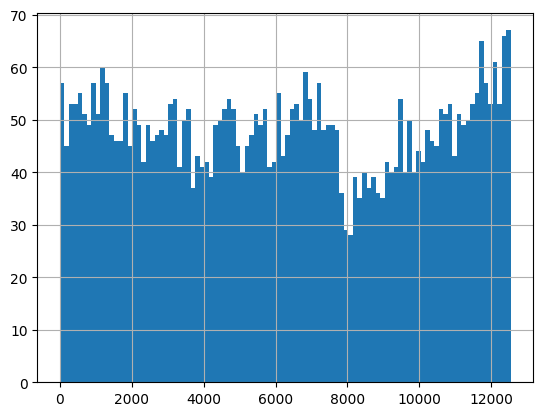

In [11]:
pd.Series(census_nonoise_2030.household_id.str.replace('0_', '').astype(int).unique()).hist(bins=100)

<Axes: xlabel='household_id_cut', ylabel='percent_existing'>

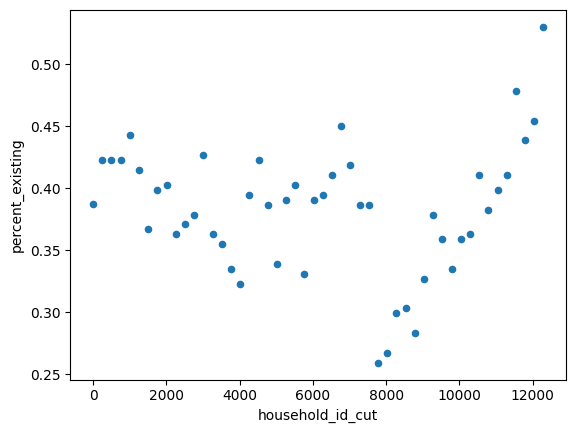

In [12]:
# There is probably a much cleaner way to do this, but looking at % household ID values that exist
(
    census_nonoise_2030
        .assign(household_id=lambda df: df.household_id.str.replace('0_', '').astype(int))
        .assign(household_id_cut=lambda df: pd.cut(df.household_id, bins=50))
        .groupby('household_id_cut').household_id.nunique().rename('num_households')
        .reset_index()
        .assign(percent_existing=lambda df: df.num_households / df.household_id_cut.map(lambda x: x.right - x.left))
        .assign(household_id_cut=lambda df: df.household_id_cut.map(lambda x: x.left))
        .plot(kind='scatter', x='household_id_cut', y='percent_existing')
)

<Axes: xlabel='household_id_cut', ylabel='household_size'>

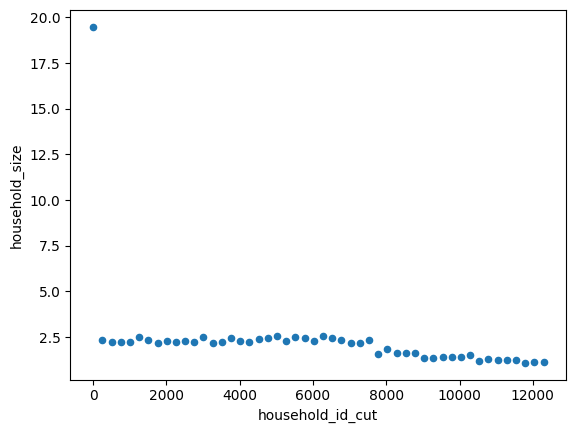

In [13]:
# There is probably a much cleaner way to do this, but looking at household size by household ID
(
    census_nonoise_2030.household_id.str.replace('0_', '').astype(int).value_counts().rename('household_size').reset_index().rename(columns={'index': 'household_id'})
        .assign(household_id_cut=lambda df: pd.cut(df.household_id, bins=50))
        .groupby('household_id_cut').household_size.mean()
        .reset_index()
        .assign(household_id_cut=lambda df: df.household_id_cut.map(lambda x: x.left))
        .plot(kind='scatter', x='household_id_cut', y='household_size')
)

In [14]:
# What is special about the last household IDs? Maybe created through new-household moves?
simulants_in_last_households = census_nonoise_2030[census_nonoise_2030.household_id.str.replace('0_', '').astype(int) >= 8_000].simulant_id
taxes = pd.concat([
    # Taxes 2029 is about when the Census 2030 happens
    psp.generate_taxes_w2_and_1099(year=year, config=psp.NO_NOISE) for year in range(2019, 2029)
], ignore_index=True)

In [15]:
(
    taxes
        .pipe(lambda df: df[df.simulant_id.isin(simulants_in_last_households)])
        .groupby('simulant_id').household_id.nunique().mean()
)

1.60196828868234

In [16]:
taxes.groupby('simulant_id').household_id.nunique().mean()

1.2436324223890995

In [17]:
# More likely to have moved between households -- and about half were observed to do so.
# This makes sense, because half of new-household moves would be coming from the
# half of PUMAs that are unobserved.
(
    (taxes
        .pipe(lambda df: df[df.simulant_id.isin(simulants_in_last_households)])
        .groupby('simulant_id').household_id.nunique() > 1).mean()
)

0.4953526517222526

### Cursory examination of the 1040

In [18]:
tax_1040 = psp.generate_taxes_1040(year=2035)
tax_1040

,simulant_id,household_id,first_name,middle_initial,last_name,ssn,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_city,mailing_address_state,mailing_address_zipcode,spouse_first_name,spouse_middle_initial,spouse_last_name,spouse_ssn,dependent_1_first_name,dependent_1_last_name,dependent_1_ssn,dependent_2_first_name,dependent_2_last_name,dependent_2_ssn,dependent_3_first_name,dependent_3_last_name,dependent_3_ssn,dependent_4_first_name,dependent_4_last_name,dependent_4_ssn,tax_year
0,0_22522,0_2995,Poppy,M,Brown,003-04-5334,3325,nrth street,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
1,0_21,0_14,Gianna,R,Sperr,037-53-5358,13208,w warren ave,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
2,0_7769,0_14736,Tracey,T,Paye,636-88-4449,192,central street,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
3,0_26,0_16,NaN,B,Blackwell,020-55-2522,57,shadowood dr,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
4,0_45,0_21,Clarence,C,Ramirez,391-40-2909,2207,church st,# 2 floor,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9255,0_19449,0_6130,Michael,W,Apo,245-80-7979,47,cr 962b,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
9256,0_20352,0_5570,Ronan,S,Hansley,295-10-8584,NaN,NaN,NaN,11076,Anytown,WA,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
9257,0_5300,0_8256,Colleen,R,Tilghman,860-25-2530,1649,33 mile rd,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Erica,Tilghman,470-31-1635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035
9258,0_11561,0_8256,James,M,Garcia Cervantes,792-89-5093,1649,33 mile rd,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Anna,Garcia Cervantes,675-96-3675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035


In [19]:
tax_1040.notnull().mean()

simulant_id                      1.000000
household_id                     1.000000
first_name                       0.988337
middle_initial                   0.989633
last_name                        0.990173
ssn                              0.988985
mailing_address_street_number    0.929698
mailing_address_street_name      0.961771
mailing_address_unit_number      0.043197
mailing_address_po_box           0.029050
mailing_address_city             0.990281
mailing_address_state            0.990065
mailing_address_zipcode          0.990605
spouse_first_name                0.024514
spouse_middle_initial            0.024514
spouse_last_name                 0.024514
spouse_ssn                       0.024298
dependent_1_first_name           0.120950
dependent_1_last_name            0.120626
dependent_1_ssn                  0.120734
dependent_2_first_name           0.037041
dependent_2_last_name            0.037689
dependent_2_ssn                  0.037797
dependent_3_first_name           0

In [20]:
tax_1040[tax_1040.dependent_3_ssn.notnull()]

,simulant_id,household_id,first_name,middle_initial,last_name,ssn,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_city,mailing_address_state,mailing_address_zipcode,spouse_first_name,spouse_middle_initial,spouse_last_name,spouse_ssn,dependent_1_first_name,dependent_1_last_name,dependent_1_ssn,dependent_2_first_name,dependent_2_last_name,dependent_2_ssn,dependent_3_first_name,dependent_3_last_name,dependent_3_ssn,dependent_4_first_name,dependent_4_last_name,dependent_4_ssn,tax_year
55,0_15087,0_6079,Samantha,R,Mcfarlane,441-71-8013,6943,foxbridge cir s,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Elder,Mcfarlane,707-83-6499,Gabriel,Mcfarlane,773-34-385S,Evelyn,Mcfarlane,441-71-8013,NaN,NaN,NaN,2035
255,0_1169,0_10872,Kendra,B,Atha,132-85-7543,29,stoughton avenue,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Layla,Atha,538-16-2666,Cruz,Atha,714-61-5339,Naomi,Atha,776-55-3634,NaN,NaN,NaN,2035
317,0_17090,0_6884,Brianna,A,Ryan,111-63-2615,11591,sunset ln,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Theoden,Ryan,648-62-6103,Angelica,Ryan,313-48-5945,Elizabeth,Ryan,721-03-2868,NaN,NaN,NaN,2035
348,0_17601,0_9301,Anna,C,Clapp,315-94-0301,4131,iroquois drive,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Elisa,Clapp,336-48-6646,Angel,Clapp,184-43-6460,Harvey,Clapp,184-43-6460,NaN,NaN,NaN,2035
393,0_17376,0_15004,Katelyn,J,Hillen,818-12-0598,5521,isleswood terrace,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Adrian,Hillen,845-85-8975,Oaklynn,Hillen,335-51-7860,Zaylon,Hillen,688-07-3012,Erin,Hillen,231-14-1518,2035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8867,0_17872,0_7194,Jared,J,Amezola,767-62-3015,1498,briarcreek ct,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Lana,Amezola,742-94-6301,Levi,Amezola,742-94-6301,Mila,Amezola,628-66-7067,Enzo,Amezola,889-09-8259,2035
8929,0_7802,0_3182,Amanda,L,Baquedano,812-35-4978,5125,patuxent oak ct,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Kira,Baquedano,170-76-9147,David,Baquedano,367-13-8679,Emma,Baquedano,812-35-4978,NaN,NaN,NaN,2035
8969,0_1595,0_5976,Ariana,S,Hancock-Chavez,074-46-2128,NaN,NaN,NaN,4576,Anytown,WA,00000,NaN,NaN,NaN,NaN,Danielle,Hancock-Chavez,616-59-9657,Adriana,Hancock-Chavez,787-81-0082,Daleysa,Younger,447-59-1107,Wyatt,Hancock-Chavez,574-66-o611,2035
9030,0_12417,0_6948,Mary,L,Kemraj,345-59-2312,74-31,s wasson ln,NaN,NaN,Anytown,WA,00000,NaN,NaN,NaN,NaN,Luke,Kemraj,125-86-0114,Baker,Kemraj,261-70-8826,Nora,Kemraj,125-86-0114,NaN,NaN,NaN,2035


### Cursory examination of WIC

In [21]:
psp.generate_women_infants_and_children(year=None, config=psp.NO_NOISE)

,simulant_id,household_id,first_name,middle_initial,last_name,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,sex,race_ethnicity,year
0,0_335,0_139,Julie,L,Newell,10221985,2496,san pablo rd s,NaN,Anytown,WA,00000,Female,White,2019
1,0_337,0_139,Theodore,A,Newell,12042018,2496,san pablo rd s,NaN,Anytown,WA,00000,Male,White,2019
2,0_338,0_139,Anna,A,Newell,12042018,2496,san pablo rd s,NaN,Anytown,WA,00000,Female,White,2019
3,0_8086,0_3290,Kennedy,L,Robinson,07052005,10,e spicerville hwy,NaN,Anytown,WA,00000,Female,Black,2039
4,0_26394,0_3290,Leia,Z,Robinson,05122038,10,e spicerville hwy,NaN,Anytown,WA,00000,Female,Black,2039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,0_27015,0_16529,Luna,E,Green,10192037,330,freedom st,NaN,Anytown,WA,00000,Female,White,2041
3101,0_26990,0_3504,Everly,X,Burwell,03262040,6024,sw kristin ct,NaN,Anytown,WA,00000,Female,White,2041
3102,0_27072,0_16349,Kayden,D,Wegman,07062040,NaN,w abercrombie cir,NaN,Anytown,WA,00000,Male,White,2041
3103,0_27120,0_7250,Lana,A,Iezzi,09052040,15170,felice dv,NaN,Anytown,WA,00000,Female,White,2041


In [22]:
psp.generate_women_infants_and_children(year=None, config=psp.NO_NOISE).year.value_counts().sort_index()

2019    158
2020    141
2021    126
2022    164
2023    143
2024    140
2025    143
2026    139
2027    136
2028    132
2029    133
2030    115
2031    126
2032    124
2033    122
2034    124
2035    129
2036    128
2037    140
2038    154
2039    123
2040    137
2041    128
Name: year, dtype: int64

## Looking for noise problems

### Seed, source, config basics

In [23]:
# Seed, source, and config behavior
# decennial_census is the only one that allows non-integer seeds
for seed in [False, True, 0, -150, 150, 28740, 'foo', None]:
    result = psp.generate_decennial_census(seed=seed)
    # Reproducible
    assert result.equals(psp.generate_decennial_census(seed=seed))
    # config={} is equivalent to not passing it
    assert result.equals(psp.generate_decennial_census(seed=seed, config={}))
    # Passing the default config is equivalent
    assert result.equals(psp.generate_decennial_census(seed=seed, config=psp.get_config()))
    # Subsetting the default config to the relevant dataset is equivalent
    assert result.equals(psp.generate_decennial_census(seed=seed, config={'decennial_census': psp.get_config()['decennial_census']}))
    # Explicitly using the sample data is equivalent to not specifying
    assert result.equals(
        psp.generate_decennial_census(seed=seed, source='/ihme/homes/zmbc/mambaforge/envs/pseudopeople_testing/lib/python3.10/site-packages/pseudopeople/data/sample_datasets/')
    )

### Look at super noisy data

In [24]:
psp.generate_decennial_census(config={'decennial_census': {'column_noise': {'first_name': {'make_typos': {'cell_probability': 1, 'token_probability': 1}}}}})

,simulant_id,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year
0,0_2,0_7,Ruixhz,P,Kelly,25,05/06/1994,5112,145th st,NaN,Anytown,WA,00000,Household,Reference person,Female,NaN,2020
1,0_3,0_7,Wjhz,A,Kelly,25,09/29/1994,5112,145th st,NaN,Anytown,WA,00000,Household,Other relative,Female,White,2020
2,0_923,0_8033,Bsezps,R,Allen,76,11/03/1943,1130,mallory ln,NaN,Anytown,WA,00000,Household,Reference person,Male,Black,2020
3,0_2641,0_1066,Olefhhw,T,Lowe,61,06/01/1958,32597,delacorte dr,NaN,Anytown,WA,00000,Household,Reference person,Female,White,2020
4,0_2801,0_1138,Fufbsgrc,R,Pinard,73,03/03/1947,950,caribou lane,NaN,Anytown,WA,00000,Household,Reference person,Male,White,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10215,0_18969,0_7630,Oqhfg,E,Palmisano,87,01/11/1933,1706,lincoln ave se,NaN,Anytown,WA,00000,Household,Opposite-sex spouse,Female,White,2020
10216,0_19008,0_8361,Mimb,V,Skeeter,58,12/29/1961,7736,trophy dr,NaN,Anytown,WA,00000,Household,Reference person,Male,Black,2020
10217,0_20165,0_7999,Oohgwfkh,K,Suitt,65,04/05/1955,3506,oneill avenue,NaN,Anytown,WA,00000,Household,Reference person,Female,White,2020
10218,0_19020,0_8130,Gjehuhoq,G,Hoover,93,10/02/1926,201,edinburgh rd,NaN,Anytown,WA,00000,Household,Reference person,Female,White,2020


### Test warning for choose_wrong_option maximum

In [25]:
all_correct_tax_form = psp.generate_taxes_w2_and_1099(config={'taxes_w2_and_1099': {'column_noise': {'tax_form': {'choose_wrong_option': {'cell_probability': 0}}}}}).tax_form
max_wrong_tax_form = psp.generate_taxes_w2_and_1099(config={'taxes_w2_and_1099': {'column_noise': {'tax_form': {'choose_wrong_option': {'cell_probability': 1}}}}}).tax_form
(all_correct_tax_form != max_wrong_tax_form).mean()

2023-09-01 16:53:23.635 | pseudopeople.configuration.validator:_validate_choose_wrong_option_probability:229 - Invalid 'cell_probability' provided for dataset 'taxes_w2_and_1099' for column 'tax_form' and noise type 'choose_wrong_option'. The configured 'cell_probability' is 1, but pseudopeople can only choose the wrong option with a maximum of 0.50000 probability. This maximum will be used instead of the configured value.


0.5067567567567568

### Helper to identify noise

In [26]:
def df_does_not_equal(df1, df2):
    return (
        (df1 != df2.loc[df1.index]) &
        ~(df1.isnull() & df2.loc[df1.index].isnull())
    )

### Look at noise overall

In [27]:
noised_spots_2020 = df_does_not_equal(psp.generate_decennial_census().set_index('simulant_id'), psp.generate_decennial_census(config=psp.NO_NOISE).set_index('simulant_id'))
noised_spots_2020

,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year
simulant_id,,,,,,,,,,,,,,,,,
0_2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
0_3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0_923,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0_2641,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0_2801,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_18969,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0_19008,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0_20165,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [28]:
noised_spots_2020.mean().sort_values()

household_id                        0.000000
year                                0.000000
unit_number                         0.001566
middle_initial                      0.011448
street_number                       0.016145
housing_type                        0.016732
city                                0.018200
sex                                 0.019472
state                               0.020059
relationship_to_reference_person    0.020059
race_ethnicity                      0.021233
zipcode                             0.026125
street_name                         0.026517
age                                 0.029256
last_name                           0.032583
first_name                          0.041292
date_of_birth                       0.045988
dtype: float64

### Helper to isolate noise types

In [29]:
default_configuration = psp.get_config()

all_noise_types = list()
for dataset, dataset_config in default_configuration.items():
    all_noise_types += dataset_config['row_noise'].keys()

    for column, column_config in dataset_config['column_noise'].items():
        all_noise_types += column_config.keys()

all_noise_types = list(pd.Series(all_noise_types).unique())
all_noise_types

['do_not_respond',
 'leave_blank',
 'use_nickname',
 'use_fake_name',
 'make_phonetic_errors',
 'make_ocr_errors',
 'make_typos',
 'copy_from_household_member',
 'misreport_age',
 'swap_month_and_day',
 'write_wrong_digits',
 'choose_wrong_option',
 'write_wrong_zipcode_digits',
 'omit_row']

In [30]:
def disable_noise_types(noise_types):
    column_noise_value = lambda dataset, column, noise_type, default_value: {'cell_probability': 0} if noise_type in noise_types else default_value
    row_noise_value = lambda dataset, noise_type, default_value: {'row_probability': 0} if noise_type in noise_types else default_value 

    custom_configuration = {
        dataset: {
            noise_category: (
                ({
                    column: {
                        noise_type: column_noise_value(dataset, column, noise_type, noise_type_config)
                        for noise_type, noise_type_config in column_config.items()
                    }
                    for column, column_config in noise_category_config.items()
                }
                if noise_category == "column_noise" else
                {
                    noise_type: row_noise_value(dataset, noise_type, noise_type_config)
                    for noise_type, noise_type_config in noise_category_config.items()
                })
            )
            for noise_category, noise_category_config in dataset_config.items()
        }
        for dataset, dataset_config in default_configuration.items()
    }

    return custom_configuration

def only_noise_types(noise_types):
    return disable_noise_types(set(all_noise_types) - set(noise_types))

In [31]:
# Check that only_noise_types is working
assert (df_does_not_equal(
    psp.generate_decennial_census(config=only_noise_types([]), seed=seed).set_index('simulant_id'),
    psp.generate_decennial_census(config=psp.NO_NOISE, seed=seed).set_index('simulant_id'),
).mean() == 0).all()

In [32]:
%%time

# Look at all noise types, at default levels

noise_type_results = {t: 0.0 for t in all_noise_types}
seeds = range(10)

for seed in seeds:
    no_noise_df = psp.generate_decennial_census(seed=seed, config=psp.NO_NOISE).set_index('simulant_id')
    for noise_type in all_noise_types:
        if noise_type in ('do_not_respond', 'omit_row'):
            noise_type_results[noise_type] += (1 - (len(psp.generate_decennial_census(config=only_noise_types([noise_type]), seed=seed)) / len(no_noise_df))) / len(seeds)
        else:
            noise_type_results[noise_type] += df_does_not_equal(
                psp.generate_decennial_census(config=only_noise_types([noise_type]), seed=seed).set_index('simulant_id'),
                no_noise_df,
            ).mean() / len(seeds)

CPU times: user 2min 53s, sys: 3.38 s, total: 2min 57s
Wall time: 2min 52s


In [33]:
for noise_type, result in noise_type_results.items():
    if isinstance(result, float):
        print(f'\n\n{noise_type}: {result}')
    else:
        print('\n\n' + noise_type)
        print(result.sort_values())



do_not_respond: 0.01618369115240206


leave_blank
household_id                        0.000000
year                                0.000000
unit_number                         0.000558
housing_type                        0.009579
last_name                           0.009647
street_number                       0.009704
middle_initial                      0.009724
date_of_birth                       0.009801
age                                 0.009935
state                               0.009935
zipcode                             0.009993
sex                                 0.010041
first_name                          0.010041
city                                0.010090
race_ethnicity                      0.010234
street_name                         0.010301
relationship_to_reference_person    0.010349
dtype: float64


use_nickname
household_id                        0.000000
sex                                 0.000000
relationship_to_reference_person    0.000000
housing_type      

In [34]:
%%time

# Look at all noise types, cumulatively stacking, at default levels

noise_type_set_results = {}
seeds = range(10)

for seed in seeds:
    no_noise_df = psp.generate_decennial_census(seed=seed, config=psp.NO_NOISE).set_index('simulant_id')
    for i in range(len(all_noise_types)):
        noise_types = tuple(all_noise_types[:i + 1])
        if noise_types not in noise_type_set_results:
            noise_type_set_results[noise_types] = 0
        noise_type_set_results[noise_types] += df_does_not_equal(
            psp.generate_decennial_census(config=only_noise_types(noise_types), seed=seed).set_index('simulant_id'),
            no_noise_df,
        ).mean() / len(seeds)

CPU times: user 5min 18s, sys: 4.01 s, total: 5min 22s
Wall time: 5min 18s


In [35]:
for noise_type_set, result in noise_type_set_results.items():
    print('\n\n' + str(noise_type_set))
    print(result.sort_values())



('do_not_respond',)
household_id                        0.0
sex                                 0.0
relationship_to_reference_person    0.0
housing_type                        0.0
zipcode                             0.0
state                               0.0
city                                0.0
race_ethnicity                      0.0
unit_number                         0.0
street_number                       0.0
date_of_birth                       0.0
age                                 0.0
last_name                           0.0
middle_initial                      0.0
first_name                          0.0
street_name                         0.0
year                                0.0
dtype: float64


('do_not_respond', 'leave_blank')
household_id                        0.000000
year                                0.000000
unit_number                         0.000558
housing_type                        0.009619
last_name                           0.009650
street_number         

### Looking at copy from household member

In [36]:
df_does_not_equal(
    psp.generate_decennial_census(config=only_noise_types(['copy_from_household_member'])),
    psp.generate_decennial_census(config=psp.NO_NOISE),
).mean()

simulant_id                         0.000000
household_id                        0.000000
first_name                          0.000000
middle_initial                      0.000000
last_name                           0.000000
age                                 0.007798
date_of_birth                       0.010783
street_number                       0.000000
street_name                         0.000000
unit_number                         0.000000
city                                0.000000
state                               0.000000
zipcode                             0.000000
housing_type                        0.000000
relationship_to_reference_person    0.000000
sex                                 0.000000
race_ethnicity                      0.000000
year                                0.000000
dtype: float64

In [37]:
copied_age = (
    psp.generate_decennial_census(config=only_noise_types(['copy_from_household_member']))
        .pipe(lambda df: df[df_does_not_equal(df, census_nonoise).age])
)

recipients_nonoise = census_nonoise.loc[copied_age.index]
copied_age.compare(recipients_nonoise, keep_shape=True, keep_equal=True, result_names=('noised', 'original'))

simulant_id          household_id          first_name            \
           noised original       noised original     noised  original   
685         0_550    0_550        0_223    0_223   Benjamin  Benjamin   
692        0_1587   0_1587        0_643    0_643     Daniel    Daniel   
900        0_1662   0_1662        0_678    0_678    Brandon   Brandon   
936       0_16430  0_16430       0_6631   0_6631      Annie     Annie   
938       0_17228  0_17228       0_6943   0_6943      Jacob     Jacob   
...           ...      ...          ...      ...        ...       ...   
9852      0_11189  0_11189       0_4537   0_4537      Donna     Donna   
9861      0_11222  0_11222       0_4547   0_4547     Yasmin    Yasmin   
9863      0_11224  0_11224       0_4547   0_4547    Abigail   Abigail   
9870      0_18151  0_18151       0_7298   0_7298   Nicholas  Nicholas   
10147     0_17554  0_17554       0_7069   0_7069      Darin     Darin   

      middle_initial          last_name              age           \
              noised original    noised  original noised original   
685                A        A   Metcalf   Metcalf     58       20   
692                O        O      Cobb      Cobb      7        8   
900                M        M   Metzger   Metzger     33       37   
936                M        M  Schwartz  Schwartz     37       77   
938                K        K    Duffin    Duffin      0       61   
...              ...      ...       ...       ...    ...      ...   
9852               K        K     Lytle     Lytle     33       36   
9861               J        J   Navarro   Navarro     41       46   
9863               R        R   Navarro   Navarro     17        8   
9870               C        C   Monarca   Monarca      3        1   
10147              B        B    Clover    Clover     23       51   

      date_of_birth             street_number               street_name  \
             noised    original        noised original           noised   
685      08/17/1999  08/17/1999          6162     6162  twyckenham blvd   
692      03/11/2012  03/11/2012          8092     8092    canwick court   
900      11/07/1982  11/07/1982          2211     2211   meadow lark rd   
936      04/16/1942  04/16/1942         10336    10336     magnolia bnd   
938      01/11/1959  01/11/1959            18       18           skyway   
...             ...         ...           ...      ...              ...   
9852     05/10/1983  05/10/1983          5338     5338           s 50 w   
9861     01/02/1974  01/02/1974          2400     2400  division street   
9863     07/02/2011  07/02/2011          2400     2400  division street   
9870     12/04/2018  12/04/2018          2041     2041   penstock drive   
10147    12/02/1968  12/02/1968          4902     4902      raymond avn   

                       unit_number              city           state           \
              original      noised original   noised original noised original   
685    twyckenham blvd         NaN      NaN  Anytown  Anytown     WA       WA   
692      canwick court         NaN      NaN  Anytown  Anytown     WA       WA   
900     meadow lark rd         NaN      NaN  Anytown  Anytown     WA       WA   
936       magnolia bnd         NaN      NaN  Anytown  Anytown     WA       WA   
938             skyway         NaN      NaN  Anytown  Anytown     WA       WA   
...                ...         ...      ...      ...      ...    ...      ...   
9852            s 50 w         NaN      NaN  Anytown  Anytown     WA       WA   
9861   division street         NaN      NaN  Anytown  Anytown     WA       WA   
9863   division street         NaN      NaN  Anytown  Anytown     WA       WA   
9870    penstock drive         NaN      NaN  Anytown  Anytown     WA       WA   
10147      raymond avn         NaN      NaN  Anytown  Anytown     WA       WA   

      zipcode          housing_type             \
       noised original       noised   original   
685     00000    00000    Ho

In [38]:
possible_donors = recipients_nonoise.join(copied_age.age.rename('copied_age')).add_prefix('recipient_').merge(census_nonoise[~census_nonoise.simulant_id.isin(recipients_nonoise.simulant_id)], left_on=['recipient_household_id', 'recipient_copied_age'], right_on=['household_id', 'age'])
# No way to tell who it was copied from if there were multiple, but this should be rare
possible_donors = possible_donors.groupby(['recipient_simulant_id']).first()
(
    recipients_nonoise.rename(columns={'simulant_id': 'recipient_simulant_id'}).set_index('recipient_simulant_id')
        .compare(possible_donors.drop(columns=[c for c in possible_donors.columns if 'recipient_' in c or c == 'simulant_id']).loc[copied_age.set_index('simulant_id').index], keep_shape=True, keep_equal=True, result_names=('recipient', 'donor'))
)

household_id         first_name           middle_initial        \
           recipient   donor  recipient     donor      recipient donor   
0_550          0_223   0_223   Benjamin   Tawanda              A     B   
0_1587         0_643   0_643     Daniel   Kennedy              O     M   
0_1662         0_678   0_678    Brandon    Arthur              M     J   
0_16430       0_6631  0_6631      Annie    Justin              M     M   
0_17228       0_6943  0_6943      Jacob  Benjamin              K     C   
...              ...     ...        ...       ...            ...   ...   
0_11189       0_4537  0_4537      Donna   Michael              K     W   
0_11222       0_4547  0_4547     Yasmin   Anthony              J     R   
0_11224       0_4547  0_4547    Abigail     Anahy              R     S   
0_18151       0_7298  0_7298   Nicholas    Darius              C     C   
0_17554       0_7069  0_7069      Darin   Matthew              B     J   

        last_name                age       date_of_birth              \
        recipient    donor recipient donor     recipient       donor   
0_550     Metcalf  Metcalf        20    58    08/17/1999  03/23/1962   
0_1587       Cobb     Cobb         8     7    03/11/2012  12/08/2012   
0_1662    Metzger  Metzger        37    33    11/07/1982  11/08/1986   
0_16430  Schwartz    Prado        77    37    04/16/1942  10/10/1982   
0_17228    Duffin   Duffin        61     0    01/11/1959  12/15/2019   
...           ...      ...       ...   ...           ...         ...   
0_11189     Lytle    Lytle        36    33    05/10/1983  11/03/1986   
0_11222   Navarro  Navarro        46    41    01/02/1974  08/14/1978   
0_11224   Navarro  Navarro         8    17    07/02/2011  10/30/2002   
0_18151   Monarca  Monarca         1     3    12/04/2018  09/17/2016   
0_17554    Clover   Clover        51    23    12/02/1968  10/25/1996   

        street_number             street_name                  unit_number  \
            recipient  donor        recipient            donor   recipient   
0_550            6162   6162  twyckenham blvd  twyckenham blvd         NaN   
0_1587           8092   8092    canwick court    canwick court         NaN   
0_1662           2211   2211   meadow lark rd   meadow lark rd         NaN   
0_16430         10336  10336     magnolia bnd     magnolia bnd         NaN   
0_17228            18     18           skyway           skyway         NaN   
...               ...    ...              ...              ...         ...   
0_11189          5338   5338           s 50 w           s 50 w         NaN   
0_11222          2400   2400  division street  division street         NaN   
0_11224          2400   2400  division street  division street         NaN   
0_18151          2041   2041   penstock drive   penstock drive         NaN   
0_17554          4902   4902      raymond avn      raymond avn         NaN   

                   city              state         zipcode         \
        donor recipient    donor recipient donor recipient  donor   
0_550    None   Anytown  Anytown        WA    WA     00000  00000   
0_1587   None   Anytown  Anytown        WA    WA     00000  00000   
0_1662   None   Anytown  Anytown        WA    WA     00000  00000   
0_16430  None   Anytown  Anytown        WA    WA     00000  00000   
0_17228  None   Anytown  Anytown        WA    WA     00000  00000   
...       ...       ...      ...       ...   ...       ...    ...   
0_11189  None   Anytown  Anytown        WA    WA     00000  00000   
0_11222  None   Anytown  Anytown        WA    WA     00000  00000   
0_11224  None   Anytown  Anytown        WA    WA     00000  00000   
0_18151  None   Anytown  Anytown        WA    WA     00000  00000   
0_17554  None   Anytown  Anytown        WA    WA     00000  00000   

        housing_type            relationship_to_reference_person  \
           recipient      donor                        recipient   
0_550      Household  Household                 Biological 

In [39]:
# We set this default to zero
df_does_not_equal(
    psp.generate_taxes_w2_and_1099(config=only_noise_types(['copy_from_household_member'])),
    psp.generate_taxes_w2_and_1099(config=psp.NO_NOISE),
).mean()

simulant_id                      0.0
household_id                     0.0
ssn                              0.0
wages                            0.0
employer_id                      0.0
employer_name                    0.0
employer_street_number           0.0
employer_street_name             0.0
employer_unit_number             0.0
employer_city                    0.0
employer_state                   0.0
employer_zipcode                 0.0
first_name                       0.0
middle_initial                   0.0
last_name                        0.0
mailing_address_street_number    0.0
mailing_address_street_name      0.0
mailing_address_unit_number      0.0
mailing_address_po_box           0.0
mailing_address_city             0.0
mailing_address_state            0.0
mailing_address_zipcode          0.0
tax_form                         0.0
tax_year                         0.0
dtype: float64

In [40]:
# But it can be configured
conf = only_noise_types(['copy_from_household_member'])
conf['taxes_w2_and_1099']['column_noise']['ssn']['copy_from_household_member']['cell_probability'] = 0.01 

df_does_not_equal(
    psp.generate_taxes_w2_and_1099(config=conf),
    psp.generate_taxes_w2_and_1099(config=psp.NO_NOISE),
).mean()

simulant_id                      0.000000
household_id                     0.000000
ssn                              0.010329
wages                            0.000000
employer_id                      0.000000
employer_name                    0.000000
employer_street_number           0.000000
employer_street_name             0.000000
employer_unit_number             0.000000
employer_city                    0.000000
employer_state                   0.000000
employer_zipcode                 0.000000
first_name                       0.000000
middle_initial                   0.000000
last_name                        0.000000
mailing_address_street_number    0.000000
mailing_address_street_name      0.000000
mailing_address_unit_number      0.000000
mailing_address_po_box           0.000000
mailing_address_city             0.000000
mailing_address_state            0.000000
mailing_address_zipcode          0.000000
tax_form                         0.000000
tax_year                         0

In [41]:
df_does_not_equal(
    psp.generate_taxes_1040(config=only_noise_types(['copy_from_household_member'])),
    psp.generate_taxes_1040(config=psp.NO_NOISE),
).mean()

simulant_id                      0.000000
household_id                     0.000000
first_name                       0.000000
middle_initial                   0.000000
last_name                        0.000000
ssn                              0.010279
mailing_address_street_number    0.000000
mailing_address_street_name      0.000000
mailing_address_unit_number      0.000000
mailing_address_po_box           0.000000
mailing_address_city             0.000000
mailing_address_state            0.000000
mailing_address_zipcode          0.000000
spouse_first_name                0.000000
spouse_middle_initial            0.000000
spouse_last_name                 0.000000
spouse_ssn                       0.009359
dependent_1_first_name           0.000000
dependent_1_last_name            0.000000
dependent_1_ssn                  0.010433
dependent_2_first_name           0.000000
dependent_2_last_name            0.000000
dependent_2_ssn                  0.010433
dependent_3_first_name           0

In [42]:
# There is no warning about the maximum
conf = only_noise_types(['copy_from_household_member'])
conf['taxes_w2_and_1099']['column_noise']['ssn']['copy_from_household_member']['cell_probability'] = 1

df_does_not_equal(
    psp.generate_taxes_w2_and_1099(config=conf),
    psp.generate_taxes_w2_and_1099(config=psp.NO_NOISE),
).mean()

simulant_id                      0.000000
household_id                     0.000000
ssn                              0.695046
wages                            0.000000
employer_id                      0.000000
employer_name                    0.000000
employer_street_number           0.000000
employer_street_name             0.000000
employer_unit_number             0.000000
employer_city                    0.000000
employer_state                   0.000000
employer_zipcode                 0.000000
first_name                       0.000000
middle_initial                   0.000000
last_name                        0.000000
mailing_address_street_number    0.000000
mailing_address_street_name      0.000000
mailing_address_unit_number      0.000000
mailing_address_po_box           0.000000
mailing_address_city             0.000000
mailing_address_state            0.000000
mailing_address_zipcode          0.000000
tax_form                         0.000000
tax_year                         0

### Testing possible_age_differences

In [43]:
conf = only_noise_types(['misreport_age'])
conf['decennial_census']['column_noise']['age']['misreport_age']['cell_probability'] = 1
conf['decennial_census']['column_noise']['age']['misreport_age']['possible_age_differences'] = {-1: 0.9, 5: 0.1}

census_with_age_differences = psp.generate_decennial_census(config=conf)
noised_ages = census_with_age_differences.age.astype(int)
true_ages = census_nonoise.age.astype(int)

# In very rare cases, it flips around at zero
(noised_ages - true_ages).value_counts() / len(census_nonoise)

-1    0.895254
 5    0.096370
 1    0.008376
Name: age, dtype: float64

In [44]:
(noised_ages[true_ages >= 1] - true_ages[true_ages >= 1]).value_counts() / len(census_nonoise[true_ages >= 1])

-1    0.904044
 5    0.095956
Name: age, dtype: float64

### Testing do_not_respond

#### Rhode Island (big, but not perfectly nationally representative)

In [45]:
RI_PATH = '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/release_02_yellow/full_data/united_states_of_america/2023_08_21_16_35_27/final_results/2023_08_31_15_58_01/states/pseudopeople_input_data_rhode_island/'

In [46]:
acs_ri = psp.generate_american_community_survey(source=RI_PATH)
acs_ri

Applying noise:  86%|████████▌ | 12/14 [00:00<00:00, 34.15type/s]


,simulant_id,household_id,survey_date,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity
0,103_652707,103_262256,2020-06-16,Ryan,P,Saenz,37,07/29/1982,18651,keen street,NaN,lincoln,RI,02860,Household,Reference person,Male,Latino
1,1061_245665,1061_98878,2020-03-24,Lorin,R,Zieba,61,11/03/1958,8114,w 127th pl,NaN,bristol,RI,02813,Household,Reference person,Male,White
2,1061_754487,1061_303835,2020-05-19,Robert,S,Stoll,15,12/21/2004,28,hampton road,NaN,newport,RI,02895,Household,Biological child,Male,White
3,1061_754488,1061_303835,2020-05-19,Kaylee,H,Stoll,11,10/26/2009,28,hampton road,NaN,newport,RI,02895,Household,Biological child,Female,White
4,1069_717890,1069_288897,2020-10-06,Brother,C,Ho,46,09/23/1973,2838,frm brook way,NaN,coventry,RI,02859,Household,Reference person,Male,Asian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,9971_944282,9971_379364,2020-03-24,Anna,V,Muller,38,07/15/1981,132,apache ave,NaN,east greenwich,RI,02863,Household,Reference person,Female,White
1056,9971_944283,9971_379364,2020-03-24,Timothy,L,Muller,36,07/15/1981,132,apache ave,NaN,east greenwich,RI,02863,Household,Opposite-sex spouse,Male,White
1057,9971_944284,9971_379364,2020-03-24,Rayden,H,Muller,7,03/02/2012,132,apache ave,NaN,east greenwich,RI,02863,Household,Biological child,Male,White
1058,9971_944285,9971_379364,2020-03-24,Charlotte,A,Muller,4,07/07/2015,132,apache ave,NaN,east greenwich,NaN,02863,Household,Biological child,Female,White


In [47]:
acs_ri_nonoise = psp.generate_american_community_survey(source=RI_PATH, config=psp.NO_NOISE)
acs_ri_nonoise

Applying noise:  86%|████████▌ | 12/14 [00:00<00:00, 34.15type/s]


,simulant_id,household_id,survey_date,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity
0,103_652707,103_262256,2020-06-16,Ryan,P,Saenz,37,07/29/1982,18651,keen street,NaN,lincoln,RI,02860,Household,Reference person,Male,Latino
1,1061_245665,1061_98878,2020-03-24,Lorin,R,Zieba,61,11/03/1958,8114,w 127th pl,NaN,bristol,RI,02813,Household,Reference person,Male,White
2,1061_754487,1061_303835,2020-05-19,Robert,S,Stoll,15,12/21/2004,28,hampton road,NaN,newport,RI,02895,Household,Biological child,Male,White
3,1061_754488,1061_303835,2020-05-19,Kaylee,H,Stoll,10,10/26/2009,28,hampton road,NaN,newport,RI,02895,Household,Biological child,Female,White
4,1069_717890,1069_288897,2020-10-06,Benjamin,C,Ho,46,09/23/1973,2838,frm brook way,NaN,coventry,RI,02859,Household,Reference person,Male,Asian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,9971_944282,9971_379364,2020-03-24,Anna,V,Muller,38,07/15/1981,132,apache ave,NaN,east greenwich,RI,02863,Household,Reference person,Female,White
1073,9971_944283,9971_379364,2020-03-24,Timothy,L,Muller,36,01/21/1984,132,apache ave,NaN,east greenwich,RI,02863,Household,Opposite-sex spouse,Male,White
1074,9971_944284,9971_379364,2020-03-24,Rayden,H,Muller,7,03/02/2012,132,apache ave,NaN,east greenwich,RI,02863,Household,Biological child,Male,White
1075,9971_944285,9971_379364,2020-03-24,Charlotte,A,Muller,4,07/07/2015,132,apache ave,NaN,east greenwich,RI,02863,Household,Biological child,Female,White


In [48]:
acs_ri_nonresponse_configured = {
    configured_probability: psp.generate_american_community_survey(
        source=RI_PATH,
        config={'american_community_survey': {'row_noise': {'do_not_respond': {'row_probability': configured_probability}}}},
    ) for configured_probability in [0.1, 0.2, 0.5]
}

Applying noise:  86%|████████▌ | 12/14 [00:00<00:00, 33.24type/s]
                                                                 
Applying noise:  86%|████████▌ | 12/14 [00:00<00:00, 34.53type/s]


In [49]:
psp.get_config()['american_community_survey']['row_noise']['do_not_respond']['row_probability']

0.0145

In [50]:
1 - (len(acs_ri) / len(acs_ri_nonoise))

0.01578458681522743

In [51]:
{
    prob: 1 - (len(df) / len(acs_ri_nonoise))
    for prob, df in acs_ri_nonresponse_configured.items()
}    

{0.1: 0.07799442896935938, 0.2: 0.18291550603528317, 0.5: 0.3008356545961003}

Reasonably well-calibrated, up to a kind of maximum -- I suspect there is clipping of individual-level probabilities
on the high end at a certain point.

#### Sample data

RI is actually not nationally representative, so it might make more sense to look at the
sample data across many seeds, though the sample size isn't great.
Note I am using the decennial here, and used ACS (which is much smaller) for RI.

In [53]:
%%time

do_not_respond_levels = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
do_not_respond_results = {level: 0.0 for level in do_not_respond_levels}
seeds = range(50)

for seed in seeds:
    no_noise_df = psp.generate_decennial_census(
        seed=seed,
        config=psp.NO_NOISE,
    ).set_index('simulant_id')
    for do_not_respond_level in do_not_respond_levels:
        conf = only_noise_types(['do_not_respond'])
        conf['decennial_census']['row_noise']['do_not_respond']['row_probability'] = do_not_respond_level
        do_not_respond_results[do_not_respond_level] += (1 - (len(psp.generate_decennial_census(config=conf, seed=seed)) / len(no_noise_df))) / len(seeds)

CPU times: user 7min 53s, sys: 10 s, total: 8min 3s
Wall time: 7min 49s


In [54]:
do_not_respond_results

{0.01: 0.011256378165013967,
 0.05: 0.05576586117261962,
 0.1: 0.11194570135746608,
 0.15: 0.16720130932896887,
 0.2: 0.22058919803600655,
 0.3: 0.2915952633099066,
 0.5: 0.3459208626167325,
 0.7: 0.3754481563492828,
 0.9: 0.39683835563685377}

Again, we see calibration up to a sort of maximum.

### Check missingness representation

In [55]:
dataset_generation_functions = {name: func for name, func in psp.__dict__.items() if 'generate_' in name}

In [56]:
for func_name, generation_func in dataset_generation_functions.items():
    for seed in range(5):
        assert not (generation_func(seed=seed) == '').any().any()

In [57]:
# This specifically used to be empty string
psp.generate_taxes_w2_and_1099().pipe(lambda df: df[df.mailing_address_po_box.notnull()]).mailing_address_street_number.value_counts(dropna=False)

NaN    307
Name: mailing_address_street_number, dtype: int64

In [58]:
# SSN never missing in W2
psp.generate_taxes_w2_and_1099(config=psp.NO_NOISE).ssn.isnull().mean()

0.0